In [1]:
from streamlit import metric
!pip install unidecode
!pip install shap
!pip install dice_ml

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# **LIBRARY** (SEMEN)

This chapter contains all the functions that are reused for several sub-chapters

## **IMPORTS**





In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy import stats
from unidecode import unidecode

import math

from scipy.stats import boxcox

import shap
from dice_ml import Dice, Data, Model

## **DATA CLEANING**

Contains functions that transform / clean datasets

In [4]:
from sklearn.preprocessing import PowerTransformer


Function that replace values in the `<str | nan>` (with commas) with `<list | nan>`



In [5]:
def feature_list_replacement(df, features):
    for feature in features:
        df[feature] = df[feature].str.split(',')

    return df

Function for outliers removal via **quartile** method

In [6]:
def remove_outliers_by_quantile(data, features):
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

    return data

Function that remove values below the threshold for nominal feature

In [7]:
def remove_below_threshold(df, column_to_threshold):
    result_df = df.copy()

    for column, threshold in column_to_threshold.items():
      counts_column = df.explode(column)[column] if df[column].apply(lambda x: isinstance(x, list)).any() else df[column]

      value_counts = counts_column.value_counts(normalize=True)
      values_to_keep = value_counts[value_counts >= threshold].index

      result_df[column] = result_df[column].apply(lambda x: x if x in values_to_keep else np.nan)

    return result_df

## **DATA ANALYSIS**

Contains functions that show information / plot graph about dataset

Function that finds features that potentially can be splitted to lists

In [8]:
def find_candidates_for_splitting(df):
    list_features = []

    for column in df.columns:
        if not df[column].apply(lambda x: not isinstance(x, str) or len(x.split(',')) < 2).all():
            list_features.append(column)

    for feature in list_features:
        print(f"\n{feature} - {df[df[feature].str.contains(',', na=False)][feature].unique()}")

    return list_features

Function that extracts nominal and continious features

In [9]:
def extract_features_by_type(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

    return categorical_columns, numerical_columns

Function that plots pie chart with the difference of the amounts

In [10]:
def plot_difference(columns_dict):
    # Plot a pie chart for the distribution of categorical and numerical columns
    plt.figure(figsize=(8, 8))
    plt.pie(columns_dict.values(), labels=columns_dict.keys(), autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], wedgeprops={'edgecolor': 'black'})

    # Add title to the pie chart
    plt.title('Distribution of Categorical vs Numerical Columns')
    plt.show()

The class that conducts Nan-values analysis

In [11]:
class NanAnalyser:
    def __init__(self, df):
        self._df = df.copy()

    # Plot heatmap with nan-values
    def plot_nan_values_heatmap(self):
        sns.heatmap(self._df.isnull(), cbar=False, cmap="viridis")
        plt.title("Missing Values Heatmap")
        plt.show()

    def get_nan_statistic(self):
      # Calculate the count and percentage of missing values
      missing_count = preprod_train_data.isnull().sum()
      missing_percentage = (missing_count / len(preprod_train_data)) * 100

      # Display columns with missing values and their respective counts and percentages
      missing_data = missing_count[missing_count > 0]
      missing_data_percentage = missing_percentage[missing_percentage > 0]

      # Optionally, combine the count and percentage into a DataFrame for easier viewing
      missing_summary = pd.DataFrame({
          'Missing Values Count': missing_data,
          'Missing Values Percentage': missing_data_percentage
      })

      return missing_summary

The class that provide distribution plotting for numerical and categorical features

In [12]:
class DistributionAnalyser:
    def __init__(self, df):
        self._df = df.copy()

    # The function that plots numerical features distribution
    def plot_numerical_distributions(self, numerical_features, num_columns=2):
        num_features = len(numerical_features)
        num_rows = math.ceil(num_features / num_columns)

        plt.figure(figsize=(15, (num_rows + 1) * 5))

        for i, feature in enumerate(numerical_features):
            plt.subplot(num_rows, num_columns, i + 1)
            sns.histplot(self._df[feature], bins=30, kde=False)
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title(feature)

        plt.tight_layout()
        plt.show()


    # The function that plots categorical features relation frequency
    def plot_categorical_relation_frequency(self, categorical_features, num_columns=2, top_n=100, height=5):
         num_features = len(categorical_features)
         num_rows = math.ceil(num_features / num_columns)

         plt.figure(figsize=(15, num_rows * height))

         for i, feature in enumerate(categorical_features):
             plt.subplot(num_rows, num_columns, i + 1)

             # Check if the column contains list-like entries and explode if necessary
             if self._df[feature].apply(lambda x: isinstance(x, list)).any():
                 current_values = self._df.explode(feature)[feature].dropna()
             else:
                 current_values = self._df[feature].dropna()

             # Get the top_n most frequent categories
             current_values = current_values.value_counts().head(top_n) / len(self._df[feature])

             # Plotting
             sns.barplot(x=current_values.values, y=current_values.index, palette='viridis')
             plt.xlabel('Frequency')
             plt.ylabel('Value')
             plt.title(f'Distribution of {feature}')

             # Rotate y-axis labels for better readability if there are many categories
             if len(current_values) > 10 or any(len(str(label)) > 15 for label in current_values.index):
                 plt.yticks(rotation=0)

         plt.tight_layout()
         plt.show()


The function that plot correlation matrix

In [13]:
def plot_correlation_matrix(df, method='spearman'):
    corr_matrix = df.corr(method=method)

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True, square=True)
    plt.title(f'Correlation Heatmap ({method})')
    plt.show()

## **STATISTICAL TESTING**

Contains functions that provide stat testing

In [14]:
SIGNIFICANT_LEVEL = 0.05

Normality check

In [15]:
# The function prove hypothesis H0: "The data is normally distributed"
# H1 then "The data is not normally distributed"
# I used Shapiro-Wilk’s W test for the proving
def check_normality(dataset):
    test, pvalue = stats.shapiro(dataset)

    return pvalue >= SIGNIFICANT_LEVEL

Variance uniform check

In [16]:
# The function prove hypothesis H0: "The variances of the datasets are the same."
# H1 then "The variances of the datasets are different"
def check_variance_uniform(*args):
    test, pvalue = stats.levene(*args)

    return pvalue >= SIGNIFICANT_LEVEL

Non-parametrized stat testing

In [17]:
# In our case, data obtained from a single source can be considered paired
# We cannot use parameterized tests if the conditions are not met
# Within the framework of this function, we are trying to determine whether our hypothesis can be confirmed statistically adequately under current conditions
# The test "Kruskal-Wallis H test" is used for that situation
def get_p_statistical_adequacy_non_parametrised(*args):
    # pvalue is one-sided, because the data is paired
    test, pvalue = stats.kruskal(*args)

    return pvalue

Parametrized stat testing

In [18]:
# The same function with one-way ANOVA that is used when we can fit to the parametrized conditions
def get_p_statistical_adequacy_parametrised(*args):
    test, pvalue = stats.f_oneway(*args)

    # pvalue is one-sided, because the data is paired
    return pvalue

Function that applies correct stat test to extract p-value

In [19]:
def extract_p_value(*args):
    # Removing series that doesn't have less than 50 values to have correct stat tests
    correct_args = tuple(arg for arg in args if len(arg) >= 10)

    normality_check = all(check_normality(arg) for arg in correct_args)
    variance_uniform_check = check_variance_uniform(*correct_args)

    if normality_check and variance_uniform_check:
        p_value = get_p_statistical_adequacy_parametrised(*correct_args)
    else:
        p_value = get_p_statistical_adequacy_non_parametrised(*correct_args)

    return p_value

Getting p-value for nominal features between their values

In [20]:
# Additional function for extraction
def search_function(name, x):
    return name in x if isinstance(x, list) else x == name

# Additional function for printing results
def visualize_p_value_result(result):
    for feature, p_value in result.items():
        print(f"Feature: {feature} - p-value: {p_value} - {'there IS the difference in mean' if p_value < SIGNIFICANT_LEVEL else 'there IS NOT the difference in mean'}")


# Get and print p-value for each of the nominal features
# Additionally returns dict: <feature>-<p-value>
def get_p_for_nominal_data(df, categorical_features, target_column):
    # Initialize a dictionary to store the results
    results = {}

    for categorical_feature in categorical_features:
        values = df[categorical_feature][df[categorical_feature].notna()]
        values = values.explode().unique() if values.apply(lambda x: isinstance(x, list)).any() else values.unique()

        # Check for not-nan
        target_values = [df[df[categorical_feature].apply(
            lambda x: (isinstance(x, str) and value == x) or
                      (isinstance(x, list) and value in x)
            )][target_column] for value in values]

        results[categorical_feature] = extract_p_value(*target_values)

    visualize_p_value_result(results)

## **FEATURE ENGINEERING**

Contains functions that change structure of the dataset

### DISTRIBUTION CHANGING

In [21]:
epsilon = 10-6

Function that applies box-cox to columns

In [22]:
def apply_box_cox(df, columns_to_apply):
    df_copied = df.copy()
    lamdba_values = {}

    for column in columns_to_apply:
        result_column, lambda_opt = boxcox(df_copied[column] + epsilon)
        df_copied[column] = result_column
        lamdba_values[column] = lambda_opt

    return df_copied, lamdba_values

Function that applies reverse box-cox to columns

In [23]:
def reverse_box_cox(series, lambda_value):
    if lambda_value == 0:
        return np.exp(series) - epsilon
    else:
        return (series * lambda_value + 1) ** (1 / lambda_value) - epsilon

### DUPLICATION

Function for datasets replication

In [24]:
def duplicate_datasets(*datasets):
    return [df.copy() for df in datasets]

### ONE-HOT ENCODING

The block below contains the class that creates **one-hot encoded features** instead of nominal features in the provided dataset

In [25]:
class OneHotEncoder:
    def __init__(self, df):
        self._df = df.copy()  # Encapsulated DataFrame

    def replace_with_one_hot_encoded(self, columns):
        prepared_features = self._get_one_hot_encoded_features(columns)

        columns_to_drop = list(prepared_features.keys())
        df_dropped = self._df.drop(columns=columns_to_drop)

        additional_dfs = pd.concat([new_df for key, new_df in prepared_features.items()], axis=1).fillna(0)

        return pd.concat([df_dropped, additional_dfs], axis=1).fillna(0)

    def set_df(self, df):
        self._df = df.copy()

    # Private method to get one-hot encoded features for multiple columns
    def _get_one_hot_encoded_features(self, columns):
        prepared_features = {}
        for column in columns:
            prepared_features[column] = self._one_hot_encode(column)

        return prepared_features

    # Private method to perform one-hot encoding on a single column
    def _one_hot_encode(self, column_name):
        values = self._df[column_name].dropna().str.split(',').explode()

        value_counts = values.value_counts()

        values = values[values.isin(value_counts.index)]

        encoded_df = pd.get_dummies(values, prefix=column_name).groupby(level=0).sum()

        empty_column = f"{column_name}_"
        encoded_df = encoded_df if empty_column not in encoded_df.columns else encoded_df.drop([empty_column], axis=1)

        return encoded_df

### SCALING

Function that uses **Z-scaling** (Standart scaler) to prepare continious features

In [26]:
def standard_scale_columns(df, columns_to_scale):
    df_scaled = df.copy()

    scaler = StandardScaler()

    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df_scaled, scaler

Reverse Z-transformation

In [27]:
def reverse_standard_scale(series, mean, std):
    original_values = series * std + mean

    if isinstance(series, pd.Series):
        return pd.Series(original_values, index=series.index, name=series.name)
    else:
        return original_values

## **MODEL TRAINING**

MAE function

In [28]:
def mae_calculation(pred, fact):
    return mean_absolute_error(pred, fact)

R^2 function

In [29]:
def r_squared(pred, fact):
    y_mean = np.mean(fact)

    total_variance = np.sum((fact - y_mean) ** 2)

    residual_variance = np.sum((fact - pred) ** 2)

    r2 = 1 - (residual_variance / total_variance)

    return r2

RMSE function

In [30]:
def rmse_calculation(pred, fact):
    return np.sqrt(mean_squared_error(pred, fact))

Classes that provide interface for training, selecting and testing models

In [31]:
BASED_MODELS = {
    'KNN': KNeighborsRegressor(),
    'RandomForest': RandomForestRegressor(),
    'MLPRegressor': MLPRegressor(random_state=42, solver='adam', warm_start=True)
}

# Class that provide cross-validation and training for the best set of hyperparameters + provide trade-off bias / variance's plot
class ModelSelector:
    def __init__(self, X, y):
        self.X = X
        self.y = y

        self.best_params = {}
        
        self.models = {}
        
        self.param_grids = {
            'KNN': {
                'n_neighbors': [3, 5, 10, 20],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            },
            'RandomForest': {
                'n_estimators': [50, 100, 200, 500, 1000],
                'max_depth': [3, 5, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2']
            },
            'MLPRegressor': {
                'hidden_layer_sizes': [(50,), (100,), (100, 100), (200,)],
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'early_stopping': [True],
                'validation_fraction': [0.1, 0.2, 0.3],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'max_iter': [1000]
            }
        }

        self.losses_ = {}
        self.best_epochs = 1500

    # Check the best hyperparameters via cross-validation
    def cross_validate_and_select(self, cv=5, scoring="r2"):
        self.losses_ = {}

        for name, model in BASED_MODELS.items():
            grid_search = GridSearchCV(model, self.param_grids[name], n_jobs=-1, cv=cv, scoring=scoring, verbose=1)

            grid_search.fit(self.X, self.y)

            print(f"Model: {name}, Best {scoring}: {grid_search.best_score_:.4f}")

            self.best_params[name] = grid_search.best_params_

            if isinstance(model, MLPRegressor):
                self.losses_[name] = grid_search.best_estimator_.loss_curve_

    # Train based on cross-validation results
    def train_all_models(self):
        models = self._get_best_models()
        
        for name, model in models.items():
            print(f"Training {name} with best hyperparameters...")

            model.fit(self.X, self.y)

            print(f"{name} trained with parameters: {self.best_params[name]}")
            
        self.models = models

    # Plot curve of the loss function of MLP
    def plot_loss_curve(self):
        if 'MLPRegressor' in self.losses_:
            plt.figure(figsize=(10, 6))
            plt.plot(self.losses_['MLPRegressor'], label=f'MLP Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'MLP Training Loss Curve')
            plt.legend()
            plt.grid(True)
            plt.show()

    def set_best_epochs(self, epochs):
        self.best_epochs = epochs
        print(f"Set MLPRegressor epochs to {epochs}")
        
    # Plot trade-off for each model 
    def plot_bias_variance_tradeoff(self, test_X, test_y):
            plt.figure(figsize=(15, 5))
            
            for i, (name, model) in enumerate(self._get_best_models().items(), 1):
                bias = []
                variance = []
                total_error = []
                
                train_sizes = np.linspace(0.1, 0.9, 10)
    
                for frac in train_sizes:
                    X_train_frac, _, y_train_frac, _ = train_test_split(
                        self.X, self.y, train_size=frac, random_state=42)
                    
                    predictions = []
    
                    for _ in range(10):  # Bootstrapping to estimate variance
                        X_sample, _, y_sample, _ = train_test_split(
                            X_train_frac, y_train_frac, train_size=frac, random_state=np.random.randint(100))
                        model.fit(X_sample, y_sample)
                        predictions.append(model.predict(test_X))
    
                    predictions = np.array(predictions)
                    mean_prediction = np.mean(predictions, axis=0)
                                   
                    # Compute bias^2, variance, and total error
                    bias_squared = np.mean((test_y - mean_prediction) ** 2)
                    variance_component = np.mean(np.var(predictions, axis=0))
                    total_error_component = bias_squared + variance_component
                    
                    bias.append(bias_squared)
                    variance.append(variance_component)
                    total_error.append(total_error_component)
    
                # Plot for the current model
                plt.subplot(1, len(self.models), i)
                plt.plot(train_sizes, bias, label="Bias^2", marker='o')
                plt.plot(train_sizes, variance, label="Variance", marker='o')
                plt.plot(train_sizes, total_error, label="Total Error", marker='o')
                plt.title(name)
                plt.xlabel("Training Fraction")
                plt.ylabel("Error")
                plt.legend()
                plt.grid()
    
            plt.tight_layout()
            plt.show()
    
    def _get_best_models(self):
        if not self.best_params:
            raise ValueError("Run 'cross_validate_and_select' first to select the best model.")
        
        models = BASED_MODELS.copy()
        
        for name, model in models.items():
            model.set_params(**self.best_params[name])

            if isinstance(model, MLPRegressor):
                self.best_params[name]['max_iter'] = self.best_epochs
                model.set_params(max_iter=self.best_epochs)
        
        return models
        


The class that provide methods for calculating the metrics on pre-trained models and drawing a plot with actual vs predicted

In [32]:
    class ModelEvaluator:
        def __init__(self, models, X, y):
            self._models = models  # Pretrained models
            self._X = X  # Features dataset
            self._y = y  # Target variable

        # Method for a metrics calculation
        def evaluate(self, metric, transform_target=None):
            evaluation_results = {}

            # Apply target transformation if a lambda is provided
            if transform_target is not None:
                transformed_y = transform_target(self._y)
            else:
                transformed_y = self._y

            # Evaluate each model
            for name, model in self._models.items():
                y_pred = model.predict(self._X)  # Get predictions

                if transform_target is not None:
                    transformed_y_pred = transform_target(y_pred)
                else:
                    transformed_y_pred = y_pred

                # Evaluate using the provided metric
                score = metric(transformed_y, transformed_y_pred)
                evaluation_results[name] = score

            return evaluation_results

        # Method for drawing a plot actual vs predicted
        def plot_predictions(self, transform_target=None):
            for name, model in self._models.items():
                plt.figure(figsize=(10, 6))

                # Apply target transformation if a lambda is provided
                if transform_target is not None:
                    transformed_y = transform_target(self._y)
                else:
                    transformed_y = self._y

                # Get predictions
                y_pred = model.predict(self._X)

                # Apply transformation to predictions if necessary
                if transform_target is not None:
                    y_pred_transformed = transform_target(y_pred)
                else:
                    y_pred_transformed = y_pred

                # Plot the actual values
                plt.scatter(transformed_y, transformed_y, color='black', label='Actual Values', alpha=0.6)

                # Plot the predicted values for the current model
                plt.scatter(transformed_y, y_pred_transformed, label=f'{name} Predictions')

                # Plot the ideal prediction line (where y_pred = y_actual)
                plt.plot([min(transformed_y), max(transformed_y)], [min(transformed_y), max(transformed_y)],
                        color='red', linestyle='--', label='Ideal Prediction (y_pred = y_actual)')

                # Set labels and title for the current model
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')
                plt.title(f'{name} - Predicted vs Actual Values')
                plt.legend()
                plt.grid(True)
                plt.show()

The class for explanation the model (SHAP values and plotting + counterfactuals)

In [241]:
class ModelExplainer:
    def __init__(self, model, model_type="regressor"):
        self._model = model
        self._model_type = model_type
        
        self._shap_values = None
        self._current_data = None

    def _predict_wrapper(self, X):
        if hasattr(self._model, "predict_proba"):
            return self._model.predict_proba(X)
        return self._model.predict(X)

    def compute_shap_values(self, data):
        explainer = shap.Explainer(self._predict_wrapper, data)
        self._current_data = data
        self._shap_values = explainer(data)
        
    def plot_shap_summary(self):
        if self._shap_values is None or self._current_data is None:
            raise ValueError("Data must be provided to compute SHAP values.")
        
        plt.figure(figsize=(16, 10))
        shap.summary_plot(self._shap_values.values, features=self._current_data, feature_names=self._current_data.columns, show=True)
        
    def generate_counterfactuals(self, train_df, cont_features, target_feature, test_df_x):
        diceSet = Data(dataframe=train_df, continuous_features=cont_features, outcome_name=target_feature)
        model = Model(model=self._model, backend="sklearn", model_type="regressor")
        exp = Dice(diceSet, model, method="random")
        
        query_instances = test_df_x.sample(n=3, random_state=42)
                
        genetic_count = exp.generate_counterfactuals(query_instances, total_CFs=10, desired_range=[train_df[target_feature].min(), train_df[target_feature].max()])
        
        genetic_count.visualize_as_dataframe(show_only_changes=True)

# **PROJECT CONTEXT AND OBJECTIVES** (NEEDS TO BE RECHECKED + EXPANDED WITH REST DATASETS) - (MEL)

**The overarching goal of this project is to address the research question:**

"How can film studios leverage machine learning to optimize movie investment decisions by accurately predicting a film's openings weekend potential using pre-production features?"

This question aligns with the business need to minimize investment risks and maximize returns by making informed decisions during the pre-production stage. By focusing on key movie features such as studio, rating, runtime, cast, director, genre, production budget, and creative type, we aim to build a robust machine learning model that can predict box office performance with high accuracy. These features were chosen based on their potential influence on audience appeal and revenue generation.

In [34]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [35]:
# File paths for the datasets
data_files = {
    "metaClean43Brightspace": './metaClean43Brightspace.xlsx',
    "sales": './sales.xlsx'
}

## **DATA LOADING**

In [36]:
# Service unction to load and clean Excel files
def load_and_clean_excel(file_path):
    """Load an Excel file and clean it by dropping empty rows and columns."""
    df = pd.read_excel(file_path)
    df_cleaned = df.dropna(how='all').dropna(axis=1, how='all')
    return df_cleaned

In [37]:
# Load relevant datasets
datasets = {}
for name, file_path in data_files.items():
    print(f"Loading {name}...")
    datasets[name] = load_and_clean_excel(file_path)
    print(f"{name} loaded with shape: {datasets[name].shape}\n")

Loading metaClean43Brightspace...
metaClean43Brightspace loaded with shape: (11364, 13)

Loading sales...
sales loaded with shape: (30612, 15)



## **KEYS PREPARATION**

The create_common_key function is crucial for merging datasets. It creates a unique Key_Title column by combining normalized movie titles and release years. Normalization includes:
Lowercasing and stripping text for uniformity.
Removing special characters using unidecode and regex.
Sorting and indexing to handle duplicate titles with the same release year.
This ensures a consistent identifier across datasets, facilitating accurate merging and reducing errors caused by discrepancies in raw data.

In [38]:
# Create a common key for merging
def create_common_key(df, year_column="year"):
    """Create a Key_Title column using the normalized title and release year."""
    if year_column in df.columns:
        if year_column == "RelDate":
            df['year'] = pd.to_datetime(df[year_column], errors='coerce').dt.year
        else:
            df['year'] = df[year_column]
    else:
        print(f"{year_column} column not found.")
        return df

    if 'title' in df.columns:
        df['normalized_title'] = df['title'].astype(str).str.lower().str.strip()
        df['normalized_title'] = df['normalized_title'].apply(lambda x: unidecode(x))
        df['normalized_title'] = df['normalized_title'].str.replace(r'[^\w\s]', '', regex=True)
        df = df.sort_values(by=['normalized_title', 'year'], ascending=[True, True])
        df['KeyIndex'] = df.groupby(['normalized_title', 'year']).cumcount() + 1
        df['Key_Title'] = df['normalized_title'].str.title() + df['year'].astype(str) + df['KeyIndex'].astype(str)
        return df
    else:
        print("Title column not found.")
        return df

After that the both of the datasets are prepared to merging

In [39]:
# Prepare datasets for merging
meta_clean = create_common_key(datasets["metaClean43Brightspace"], year_column="RelDate")
sales = create_common_key(datasets["sales"], year_column="year")

The results are located below

In [40]:
meta_clean

,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate,year,normalized_title,KeyIndex,Key_Title
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11,2016,10 cloverfield lane,1,10 Cloverfield Lane20161
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01,2006,10 items or less,1,10 Items Or Less20061
3,https://www.metacritic.com/movie/10-years,10 Years,Anchor Bay Entertainment,| R,100.0,"Channing Tatum,Chris Pratt,Jenna Dewan",Jamie Linden,"Drama,Comedy,Romance",NaN,NaN,61,6.9,2012-09-14,2012,10 years,1,10 Years20121
4,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"Horror,Comedy",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28,2013,100 bloody acres,1,100 Bloody Acres20131
5,https://www.metacritic.com/movie/100-streets,100 Streets,Samuel Goldwyn Films,NaN,93.0,NaN,Jim O'Hanlon,Drama,NaN,NaN,44,6.1,2017-01-13,2017,100 streets,1,100 Streets20171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11359,https://www.metacritic.com/movie/zoolander-2,Zoolander 2,Paramount Pictures,| PG-13,102.0,"Ben Stiller,Kristen Wiig,Owen Wilson,PenÃ©lope...",Ben Stiller,Comedy,Derek (Ben Stiller) and Hansel (Owen Wilson) a...,"#87MostDiscussedMovieof2016 , #80MostSharedMov...",34,4.1,2016-02-12,2016,zoolander 2,1,Zoolander 220161
11360,https://www.metacritic.com/movie/zoom,Zoom,Columbia Pictures,| PG,83.0,"Chevy Chase,Courteney Cox,Tim Allen",Peter Hewitt,"Action,Adventure,Sci-Fi,Family",A former superhero (Allen) is called back into...,NaN,26,4.4,2006-08-11,2006,zoom,1,Zoom20061
11361,https://www.metacritic.com/movie/zoom-2016,Zoom,Screen Media Films,| Not Rated,96.0,NaN,Pedro Morelli,"Drama,Comedy,Animation",A multi-dimensional interface between a comic ...,NaN,55,5.7,2016-09-02,2016,zoom,1,Zoom20161
11362,https://www.metacritic.com/movie/zootopia,Zootopia,Walt Disney Studios Motion Pictures,| PG,108.0,NaN,Byron Howard,"Action,Adventure,Comedy,Crime,Animation,Family",NaN,"#80BestMovieof2016 , #11MostDiscussedMovieof20...",78,8.6,2016-03-04,2016,zootopia,1,Zootopia20161


In [41]:
sales

,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url,normalized_title,KeyIndex,Key_Title
8262,2016,April 29th,# VSE_ISPRAVIT!?!,Drama,230020.0,NaN,230020.0,NaN,NaN,NaN,NaN,98.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/VSE-ISPRAVIT...,vse_ispravit,1,Vse_Ispravit20161
9503,2017,April 13th,"0,03 Seconds",Documentary,44559.0,NaN,44559.0,NaN,NaN,NaN,NaN,90.0,NaN,Factual,https://www.the-numbers.com/movie/0-03-Seconds...,003 seconds,1,003 Seconds20171
26258,2019,May 29th,0.0MHz,Horror,922747.0,NaN,922747.0,NaN,NaN,NaN,NaN,101.0,NaN,Fantasy,https://www.the-numbers.com/movie/0-0MHz-(S-Ko...,00mhz,1,00Mhz20191
11322,2018,March 9th,01:54:00,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,Bullies,Contemporary Fiction,https://www.the-numbers.com/movie/1-54-(Canada),015400,1,01540020181
6187,2017,June 30th,02:22:00,Thriller/Suspense,4604101.0,422.0,4604523.0,NaN,294.0,3.0,1.0,99.0,Set in New York City,Contemporary Fiction,https://www.the-numbers.com/movie/2-22-(2017),022200,1,02220020171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20638,2007,April 6th,Zwartboek,Thriller/Suspense,22839822.0,4398532.0,27238354.0,22000000.0,112521.0,9.0,7.4,145.0,World War II,Historical Fiction,https://www.the-numbers.com/movie/Zwartboek,zwartboek,1,Zwartboek20071
8865,2013,February 28th,Zwei Leben,Drama,355946.0,39673.0,395619.0,NaN,1303.0,1.0,1.3,99.0,World War II,Historical Fiction,https://www.the-numbers.com/movie/Zwei-Leben,zwei leben,1,Zwei Leben20131
6458,2015,August 28th,Zyc nie umierac,Comedy,967318.0,NaN,967318.0,NaN,NaN,NaN,NaN,100.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Zyc-nie-umie...,zyc nie umierac,1,Zyc Nie Umierac20151
21726,2006,February 24th,Zyzzyx Rd.,Thriller/Suspense,NaN,20.0,NaN,NaN,20.0,1.0,1.0,NaN,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Zyzzyx-Rd,zyzzyx rd,1,Zyzzyx Rd20061


## **FEATURE LIST SPLITTING**

Some of the features contains several values divided by comma in each row. It's necessary to check which values are just specified names and which values are candidates for splitting.

In [42]:
find_candidates_for_splitting(meta_clean)


title - ['1,000 Times Good Night' '10,000 BC' '10,000 km' '2 Autumns, 3 Winters'
 '20,000 Days on Earth' '3 1/2 Minutes, 10 Bullets'
 '3, 2, 1... Frankie Go Boom' '4 Months, 3 Weeks and 2 Days'
 'A White, White Day' 'A Woman, a Gun and a Noodle Shop' 'A Woman, a Part'
 'AcasÄ\x83, My Home' 'Accidental Courtesy: Daryl Davis, Race & America'
 'After Fall, Winter'
 'Alexander and the Terrible, Horrible, No Good, Very Bad Day'
 'All Light, Everywhere' 'Anne at 13,000 ft'
 'Arabian Nights: Volume 1, The Restless One'
 'Arabian Nights: Volume 2, The Desolate One'
 'Arabian Nights: Volume 3, The Enchanted One' 'As Above, So Below'
 'Berlin, I Love You' 'Biandan, guniang'
 'Big Mommas: Like Father, Like Son' 'Bless Me, Ultima'
 'Bloody Nose, Empty Pockets'
 'Bob Ross: Happy Accidents, Betrayal & Greed' 'Booye kafoor, atre yas'
 'Broadway: The Golden Age, by the Legends Who Were There'
 'Christmas, Again'
 'Connected: An Autoblogography About Love, Death & Technology'
 'Crazy, Not Insane' 'Cra

['title', 'studio', 'cast', 'director', 'genre', 'summary', 'awards']

As it's seemed, the candidates are **"awards"**, **"cast"** and **"genre"** in meta_clean dataset.

In [43]:
find_candidates_for_splitting(sales)


title - ['0,03 Seconds' '1,000 Times More Brutal' '10,000 B.C.' '10,000 KM'
 '10,000 Miles' '10,000 Saints' '14 jours, 12 nuits'
 '1946, Calcutta Killings' '1984, Choi Dong-won' '1991, Bom'
 '2 MÃƒÂ¤nner, 2 Frauen - 4 Probleme!?' '20,000 Days on Earth'
 '3, 2, 1... Frankie Go Boom' '4 luni, 3 saptamani si 2 zile'
 '5150, Rue des Ormes' '522. Un gato, un chino y mi padre'
 '7 lagos, 7 vidas' '7 rzeczy, ktÃƒÂ³rych nie wiecie o facetach'
 'A Bread Factory, Part One: For the Sake of Gold'
 'A Bread Factory, Part Two: Walk With Me A While'
 'A Fragile Trust: Plagiarism, Power, and Jayson Blair at the New York Times'
 'A Woman, A Part' 'Ã…Â½monÃ„â€”s, kuriuos paÃ…Â¾Ã„Â¯stam'
 'Ã\x90Å¸Ã\x90ï¿½Ã\x90Â\xa0Ã\x90â€¢Ã\x90ï¿½Ã\x90Â¬ Ã\x90ËœÃ\x90â€” Ã\x90â€œÃ\x90Å¾Ã\x90â€ºÃ\x90â€ºÃ\x90ËœÃ\x90â€™Ã\x90Â£Ã\x90â€\x9dÃ\x90ï¿½, Ã\x90ËœÃ\x90â€ºÃ\x90Ëœ Ã\x90ï¿½Ã\x90â€¢Ã\x90Å¾Ã\x90â€˜Ã\x90Â«Ã\x90Å¡Ã\x90ï¿½Ã\x90Å¾Ã\x90â€™Ã\x90â€¢Ã\x90ï¿½Ã\x90ï¿½Ã\x90Â«Ã\x90â€¢ Ã\x90Å¸Ã\x90Â\xa0Ã\x90ËœÃ\x90Å¡Ã\x90â€ºÃ\x90Â®Ã\x

['title', 'keywords']

It's also possible to conclude that in the **sales** dataset there is no possible candidates for splitting

In [44]:
META_CLEAN_SPLITTED_FEATURES = ["awards", "cast", "genre"]
SALES_SPLITTED_FEATURES = []

The last step is to split features in the both datasets

In [45]:
meta_clean = feature_list_replacement(meta_clean, META_CLEAN_SPLITTED_FEATURES)
meta_clean

,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate,year,normalized_title,KeyIndex,Key_Title
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"[John Gallagher Jr., John Goodman, Mary Elizab...",Dan Trachtenberg,"[Action, Sci-Fi, Drama, Mystery, Thriller, Hor...","Waking up from a car accident, a young woman (...","[#18MostDiscussedMovieof2016 , #1MostSharedMo...",76,7.7,2016-03-11,2016,10 cloverfield lane,1,10 Cloverfield Lane20161
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"[Jonah Hill, Morgan Freeman, Paz Vega]",Brad Silberling,"[Drama, Comedy, Romance]",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01,2006,10 items or less,1,10 Items Or Less20061
3,https://www.metacritic.com/movie/10-years,10 Years,Anchor Bay Entertainment,| R,100.0,"[Channing Tatum, Chris Pratt, Jenna Dewan]",Jamie Linden,"[Drama, Comedy, Romance]",NaN,NaN,61,6.9,2012-09-14,2012,10 years,1,10 Years20121
4,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"[Horror, Comedy]",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28,2013,100 bloody acres,1,100 Bloody Acres20131
5,https://www.metacritic.com/movie/100-streets,100 Streets,Samuel Goldwyn Films,NaN,93.0,NaN,Jim O'Hanlon,[Drama],NaN,NaN,44,6.1,2017-01-13,2017,100 streets,1,100 Streets20171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11359,https://www.metacritic.com/movie/zoolander-2,Zoolander 2,Paramount Pictures,| PG-13,102.0,"[Ben Stiller, Kristen Wiig, Owen Wilson, PenÃ©...",Ben Stiller,[Comedy],Derek (Ben Stiller) and Hansel (Owen Wilson) a...,"[#87MostDiscussedMovieof2016 , #80MostSharedM...",34,4.1,2016-02-12,2016,zoolander 2,1,Zoolander 220161
11360,https://www.metacritic.com/movie/zoom,Zoom,Columbia Pictures,| PG,83.0,"[Chevy Chase, Courteney Cox, Tim Allen]",Peter Hewitt,"[Action, Adventure, Sci-Fi, Family]",A former superhero (Allen) is called back into...,NaN,26,4.4,2006-08-11,2006,zoom,1,Zoom20061
11361,https://www.metacritic.com/movie/zoom-2016,Zoom,Screen Media Films,| Not Rated,96.0,NaN,Pedro Morelli,"[Drama, Comedy, Animation]",A multi-dimensional interface between a comic ...,NaN,55,5.7,2016-09-02,2016,zoom,1,Zoom20161
11362,https://www.metacritic.com/movie/zootopia,Zootopia,Walt Disney Studios Motion Pictures,| PG,108.0,NaN,Byron Howard,"[Action, Adventure, Comedy, Crime, Animation, ...",NaN,"[#80BestMovieof2016 , #11MostDiscussedMovieof...",78,8.6,2016-03-04,2016,zootopia,1,Zootopia20161


In [46]:
sales = feature_list_replacement(sales, SALES_SPLITTED_FEATURES)
sales

,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url,normalized_title,KeyIndex,Key_Title
8262,2016,April 29th,# VSE_ISPRAVIT!?!,Drama,230020.0,NaN,230020.0,NaN,NaN,NaN,NaN,98.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/VSE-ISPRAVIT...,vse_ispravit,1,Vse_Ispravit20161
9503,2017,April 13th,"0,03 Seconds",Documentary,44559.0,NaN,44559.0,NaN,NaN,NaN,NaN,90.0,NaN,Factual,https://www.the-numbers.com/movie/0-03-Seconds...,003 seconds,1,003 Seconds20171
26258,2019,May 29th,0.0MHz,Horror,922747.0,NaN,922747.0,NaN,NaN,NaN,NaN,101.0,NaN,Fantasy,https://www.the-numbers.com/movie/0-0MHz-(S-Ko...,00mhz,1,00Mhz20191
11322,2018,March 9th,01:54:00,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,Bullies,Contemporary Fiction,https://www.the-numbers.com/movie/1-54-(Canada),015400,1,01540020181
6187,2017,June 30th,02:22:00,Thriller/Suspense,4604101.0,422.0,4604523.0,NaN,294.0,3.0,1.0,99.0,Set in New York City,Contemporary Fiction,https://www.the-numbers.com/movie/2-22-(2017),022200,1,02220020171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20638,2007,April 6th,Zwartboek,Thriller/Suspense,22839822.0,4398532.0,27238354.0,22000000.0,112521.0,9.0,7.4,145.0,World War II,Historical Fiction,https://www.the-numbers.com/movie/Zwartboek,zwartboek,1,Zwartboek20071
8865,2013,February 28th,Zwei Leben,Drama,355946.0,39673.0,395619.0,NaN,1303.0,1.0,1.3,99.0,World War II,Historical Fiction,https://www.the-numbers.com/movie/Zwei-Leben,zwei leben,1,Zwei Leben20131
6458,2015,August 28th,Zyc nie umierac,Comedy,967318.0,NaN,967318.0,NaN,NaN,NaN,NaN,100.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Zyc-nie-umie...,zyc nie umierac,1,Zyc Nie Umierac20151
21726,2006,February 24th,Zyzzyx Rd.,Thriller/Suspense,NaN,20.0,NaN,NaN,20.0,1.0,1.0,NaN,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Zyzzyx-Rd,zyzzyx rd,1,Zyzzyx Rd20061


# **PRE-PRODUCTION MODEL**

This chapter describes all the stages that are necessary to train, test, select and explain model that is based on the features that can be reached before a production has started.

The chapter consist of the following parts:
1. Merging relevant datasets and select pre-production features
2. Train / test splitting
3. EDA analysis of continious and nominal features
4. Feature engineering, i.e. one-hot encoding, unfrequent values replacement, etc.
5. Hyperparametr tuning via cross-validation, training top-models
6. Model selection via test dataset
7. Model explanation

## **FEATURE SELECTION** (SEMEN + MASOUD)
The relevant features are selected based on the business context of this project. These features were chosen with the goal of predicting the opening weekend revenue using factors that can be determined during the pre-production phase. From the metaClean dataset, features such as studio, rating, runtime, cast, director, and genre were selected. From the sales dataset, features like production budget and creative type were included. This approach ensures that the model leverages actionable insights available to film studios before production begins, aligning with the project's objective of optimizing investment decisions.

**Pre-Production Features:**

These are the elements that play a critical role in the initial planning, budgeting, and creative decisions before filming begins.

- **Production Budget**:
  - Essential for determining the scale of the film and how resources will be allocated.

- **Creative Type**:
  - Defines the genre, tone, and overall creative direction, guiding scriptwriting, casting, and production design.

- **Studio**:
  - Knowing which studio is involved helps determine production resources, distribution, and financial backing.

- **Cast**:
  - Decisions on casting are made during pre-production. The cast can affect budget, marketing strategies, and audience engagement.

- **Director**:
  - The director's previous work and creative style are key factors in pre-production planning. They influence the overall vision of the project.

- **Genre**:
  - This affects all aspects of production: from location and set design to target audience and casting.

- **Runtime**:
  - This is important in terms of structuring the film and planning the pacing during filming.
  
- **Rating**:  
  - The film's expected rating (e.g., G (General Audience), PG (Parental Guidance),  PG-13 (Parents Strongly Cautioned), R (Restricted), NC-17 (No One 17 and Under Admitted)) impacts scriptwriting, content restrictions, casting choices, and marketing decisions. It helps to determine the appropriate target audience and content guidelines.

**Pre-Production target feature**
- **Opening weekend** - numeric value that defines the amount of money that a movie earned on the first weekend

**Main problem**

Main problem is **regression** problem of predicting the opening weekend sum based on preproduction features

In [47]:
# Extract the required columns from each dataset
meta_clean_cols = ["studio", "rating", "runtime", "cast", "director", "genre", "Key_Title"]
meta_clean_selected = meta_clean[meta_clean_cols]

sales_cols = ["opening_weekend", "production_budget", "creative_type", "keywords", "theatre_count", "Key_Title"]
sales_selected = sales[sales_cols]

In [48]:
# Merge the datasets on the Key_Title
merged_preprod_data = pd.merge(meta_clean_selected, sales_selected, on="Key_Title", how="inner").set_index("Key_Title")

Printing result dataset

In [49]:
merged_preprod_data

,studio,rating,runtime,cast,director,genre,opening_weekend,production_budget,creative_type,keywords,theatre_count
Key_Title,,,,,,,,,,,
10 Cloverfield Lane20161,Paramount Pictures,| PG-13,104.0,"[John Gallagher Jr., John Goodman, Mary Elizab...",Dan Trachtenberg,"[Action, Sci-Fi, Drama, Mystery, Thriller, Hor...",24727437.0,15000000.0,Contemporary Fiction,Kidnap,3391.0
10 Years20121,Anchor Bay Entertainment,| R,100.0,"[Channing Tatum, Chris Pratt, Jenna Dewan]",Jamie Linden,"[Drama, Comedy, Romance]",22707.0,NaN,Contemporary Fiction,Ensemble,3.0
100 Bloody Acres20131,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"[Horror, Comedy]",3419.0,NaN,Contemporary Fiction,Accidental Death,13.0
10000 Bc20081,Warner Bros. Pictures,| PG-13,109.0,"[Camilla Belle, Marco Khan, Steven Strait]",Roland Emmerich,"[Adventure, Drama, Fantasy]",35867488.0,105000000.0,Historical Fiction,Visual Effects,3410.0
10000 Km20151,Broad Green Pictures,| R,99.0,NaN,Carlos Marques-Marcet,"[Drama, Comedy, Romance]",NaN,NaN,Contemporary Fiction,Romance,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Zoolander 220161,Paramount Pictures,| PG-13,102.0,"[Ben Stiller, Kristen Wiig, Owen Wilson, PenÃ©...",Ben Stiller,[Comedy],13841146.0,50000000.0,Contemporary Fiction,Directing Yourself,3394.0
Zoom20061,Columbia Pictures,| PG,83.0,"[Chevy Chase, Courteney Cox, Tim Allen]",Peter Hewitt,"[Action, Adventure, Sci-Fi, Family]",4510408.0,35000000.0,Super Hero,Independent/Other Comics,2501.0
Zoom20161,Screen Media Films,| Not Rated,96.0,NaN,Pedro Morelli,"[Drama, Comedy, Animation]",NaN,NaN,Contemporary Fiction,Artists,NaN


In [50]:
merged_preprod_data.columns

Index(['studio', 'rating', 'runtime', 'cast', 'director', 'genre',
       'opening_weekend', 'production_budget', 'creative_type', 'keywords',
       'theatre_count'],
      dtype='object')

Dataset shape

In [51]:
merged_preprod_data.shape

(8135, 11)

Dataset's description of cont. features

In [52]:
merged_preprod_data.describe()

,runtime,opening_weekend,production_budget,theatre_count
count,7970.000000,6.653000e+03,3.560000e+03,6663.000000
mean,102.238645,8.135760e+06,4.066209e+07,1070.045175
std,18.773705,1.908057e+07,4.804031e+07,1406.312585
min,21.000000,8.600000e+01,1.100000e+03,1.000000
25%,91.000000,1.395600e+04,1.000000e+07,3.000000
50%,99.000000,1.142730e+05,2.400000e+07,18.000000
75%,110.000000,9.034148e+06,5.040000e+07,2506.000000
max,808.000000,3.571150e+08,4.000000e+08,4725.000000


### **FEATURES DEFINITION CONSTANTS**

The constants with the types and names of features are located here

In [53]:
NOMINAL_SINGLE_VALUE_FEATURES = ["creative_type", "studio", "rating", "keywords", "director"]
NOMINAL_MULTIPLE_VALUE_FEATURES = ["cast", "genre"]

NOMINAL_FEATURES = NOMINAL_SINGLE_VALUE_FEATURES + NOMINAL_MULTIPLE_VALUE_FEATURES

NUMERICAL_FEATURES = ["runtime", "production_budget", "theatre_count"]
TARGET_FEATURE = "opening_weekend"

## **TRAIN / TEST SAMPLE SPLIT** (SEMEN)

As well as **opening_weekend** is target variable, it's necessary to drop all rows that doesn't have this value

In [54]:
merged_preprod_data_with_dropped_values = merged_preprod_data.dropna(subset=['opening_weekend'])
merged_preprod_data_with_dropped_values

,studio,rating,runtime,cast,director,genre,opening_weekend,production_budget,creative_type,keywords,theatre_count
Key_Title,,,,,,,,,,,
10 Cloverfield Lane20161,Paramount Pictures,| PG-13,104.0,"[John Gallagher Jr., John Goodman, Mary Elizab...",Dan Trachtenberg,"[Action, Sci-Fi, Drama, Mystery, Thriller, Hor...",24727437.0,15000000.0,Contemporary Fiction,Kidnap,3391.0
10 Years20121,Anchor Bay Entertainment,| R,100.0,"[Channing Tatum, Chris Pratt, Jenna Dewan]",Jamie Linden,"[Drama, Comedy, Romance]",22707.0,NaN,Contemporary Fiction,Ensemble,3.0
100 Bloody Acres20131,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"[Horror, Comedy]",3419.0,NaN,Contemporary Fiction,Accidental Death,13.0
10000 Bc20081,Warner Bros. Pictures,| PG-13,109.0,"[Camilla Belle, Marco Khan, Steven Strait]",Roland Emmerich,"[Adventure, Drama, Fantasy]",35867488.0,105000000.0,Historical Fiction,Visual Effects,3410.0
102 Dalmatians20001,Buena Vista Pictures,| G,100.0,"[GÃ©rard Depardieu, Glenn Close]",Kevin Lima,"[Comedy, Family]",19883351.0,85000000.0,Kids Fiction,Live Action Cartoon,2704.0
...,...,...,...,...,...,...,...,...,...,...,...
Zoolander20011,Paramount Pictures,| R,89.0,"[Ben Stiller, Owen Wilson]",Ben Stiller,[Comedy],15525043.0,28000000.0,Contemporary Fiction,Fashion,2507.0
Zoolander 220161,Paramount Pictures,| PG-13,102.0,"[Ben Stiller, Kristen Wiig, Owen Wilson, PenÃ©...",Ben Stiller,[Comedy],13841146.0,50000000.0,Contemporary Fiction,Directing Yourself,3394.0
Zoom20061,Columbia Pictures,| PG,83.0,"[Chevy Chase, Courteney Cox, Tim Allen]",Peter Hewitt,"[Action, Adventure, Sci-Fi, Family]",4510408.0,35000000.0,Super Hero,Independent/Other Comics,2501.0


It's valueable to split dataset on train/test samples before EDA to save 20% (common practice) for testing the models as a **black box**


In [55]:
preprod_train_data, preprod_test_data = train_test_split(merged_preprod_data_with_dropped_values, test_size=0.2, random_state=42)
preprod_train_data

,studio,rating,runtime,cast,director,genre,opening_weekend,production_budget,creative_type,keywords,theatre_count
Key_Title,,,,,,,,,,,
A House On A Hill20031,Calliope Films,NaN,89.0,NaN,Chuck Workman,[Drama],678.0,NaN,NaN,NaN,1.0
The Vow20121,Screen Gems,| PG-13,104.0,"[Channing Tatum, Rachel McAdams, Sam Neill]",Michael Sucsy,"[Drama, Romance]",41202458.0,30000000.0,Historical Fiction,Romance,2958.0
Antwone Fisher20021,Fox Searchlight Pictures,| PG-13,120.0,"[Denzel Washington, Derek Luke, Joy Bryant]",Denzel Washington,"[Biography, Drama, Romance]",210013.0,12500000.0,Dramatization,Biography,15.0
Tamara20061,Lions Gate Films,| R,98.0,"[Chad Faust, Jenna Dewan, Katie Stuart]",Jeremy Haft,"[Thriller, Fantasy, Horror]",29157.0,NaN,Fantasy,NaN,14.0
The Guest20141,Picturehouse,| R,99.0,"[Dan Stevens, Joel Moore, Leland Orser, Maika ...",Adam Wingard,"[Action, Mystery, Thriller]",84527.0,NaN,Contemporary Fiction,Returning Soldiers,19.0
...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,Universal Pictures,| PG,113.0,"[Jason Isaacs, Jeremy Sumpter, Lynn Redgrave, ...",P.J. Hogan,"[Adventure, Fantasy, Romance, Family]",11139495.0,100000000.0,Fantasy,Pirates,2813.0
The Good Heart20101,Magnolia Pictures,| R,95.0,NaN,Dagur KÃ¡ri,[Drama],5955.0,3800000.0,Contemporary Fiction,NaN,5.0
The Grudge 220061,Columbia Pictures,| PG-13,102.0,"[Amber Tamblyn, Arielle Kebbel, Edison Chen]",Takashi Shimizu,"[Drama, Mystery, Thriller, Horror]",20825300.0,20000000.0,Contemporary Fiction,Haunting,3211.0


## **EXPLORATORY DATA ANALYSIS (EDA)** (SEMEN + MASOUD)

This part includes the exploration of current dataset based on which the feature engeineering will be provided.

It consist of the following parts:
1. Categorical / continious features division
2. Nan-values exploration
3. Frequency and amount analysis of the categorical features
4. Distribution analysis of the continues variables
5. Continious feature correlation analysis
6. Nominal feature correlation analysis

### **CATEGORICAL / CONTINIOUS FEATURE DIVISON**

In [56]:
# Separate columns into categorical and numerical types
categorical_columns, numerical_columns = extract_features_by_type(preprod_train_data)

Print categorical feature results dtypes (to prove they're object)

In [57]:
preprod_train_data[categorical_columns].dtypes

studio           object
rating           object
cast             object
director         object
genre            object
creative_type    object
keywords         object
dtype: object

Print the same for numerical features

In [58]:
preprod_train_data[numerical_columns].dtypes

runtime              float64
opening_weekend      float64
production_budget    float64
theatre_count        float64
dtype: object

Plot the difference in the amount of numerical and nominal features

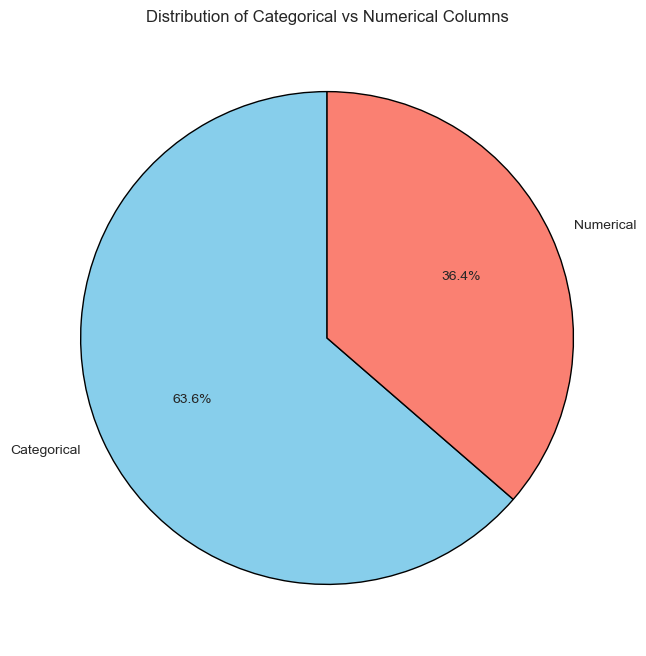

In [59]:
plot_difference({'Categorical': len(categorical_columns), 'Numerical': len(numerical_columns)})

### NAN-VALUES ANALYSIS

Create analyser class

In [60]:
nan_analyser = NanAnalyser(preprod_train_data)

Plotting the heatmap of nan-values

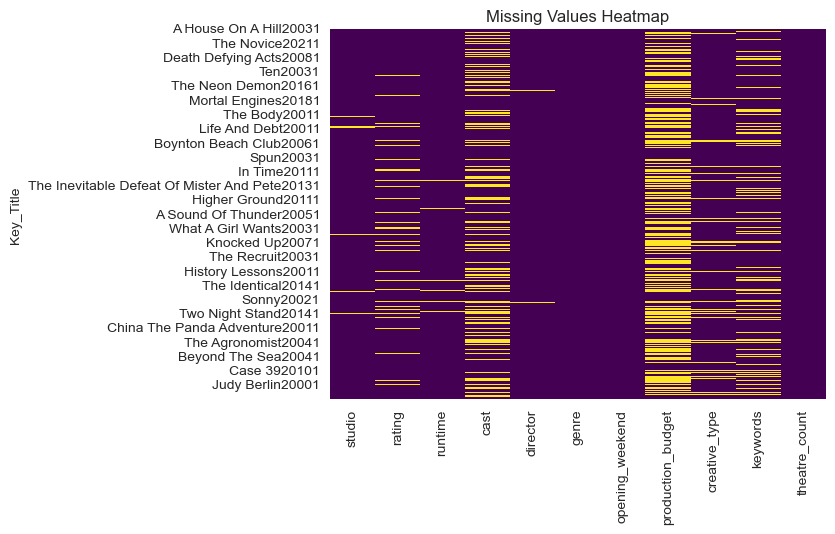

In [61]:
nan_analyser.plot_nan_values_heatmap()

Get the NaN statistic about how many NaN values do the features have

In [62]:
nan_analyser.get_nan_statistic()

,Missing Values Count,Missing Values Percentage
studio,83,1.559564
rating,370,6.952274
runtime,95,1.785043
cast,1285,24.145058
director,6,0.112740
genre,6,0.112740
production_budget,2583,48.534386
creative_type,451,8.474258
keywords,1234,23.186772
theatre_count,1,0.018790


We can see here that the following features have dramatical level of Nan values:
1. `production_budget` - almost 50% of the values are missed so it's impossible to replace NaNs with the basic statistic values (mean, median, etc.). The replacement value must be based on less non-existing feature
2. `cast` - 25% is NaN so despite that this is categorical feature it's potentially unstable for the model training

### **FREQUENCY AND AMOUNT ANALYSIS OF THE CATEGORICAL FEATURES**


Below distribution plotter has defined for the nex two chapters

In [63]:
distribution_analyser = DistributionAnalyser(preprod_train_data)

Below the exploration of the relative frequency for the categorical features that presented as a string value. Here are the results:

1. `creative_type` - the feature is well-divided, more than 70% of the rows have only 4 values, but we'll keep the rest as well as it can be interesting highlight despite the fact that other values are potentionally outliers
2. `rating` the same situation as it's goind for `creative_type`
3. `studio` - a fairly distracted feature (lead to sparse matrix), within which there is an **“elbow” transition** between relative frequency values for different values. The fiche values themselves are very large and can potentially create noise for the model, but starting from the relative frequency less than **0.01** it is recommended to **discard these values**.
4. `keywords` - the same situation as for `studio`
5. `director` - very diversed feature, almost every value appears no more than in 0.01% of the rows. Remaining this feature may lead to following troubles for our models (ElasticNet, RandomForest, and MLPRegressor):
  -  **Algorithm Compatibility**: Some algorithms, such as ElasticNet, may not support sparse matrices directly, leading to errors during model training
  - **Computational Efficiency**: Sparse matrices typically lead to big complexity and unefficial training process that requires a lot of computational resources
  -  **Model Performance**: Sparse datasets often contain numerous zero or missing values, which can hinder a model's ability to learn effectively, potentially leading to reduced predictive accuracy.

**Result recommendations**:
1. Remove values from `studio` that below 0.01 (according to the graph)
2. Drop `director`
3. Remove values from `keywords` that below 0.005 (according to the graph)

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_80596/1919121962.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=current_values.values, y=current_values.index, palette='viridis')
/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_80596/1919121962.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=current_values.values, y=current_values.index, palette='viridis')
/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_80596/1919121962.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=current_values.values,

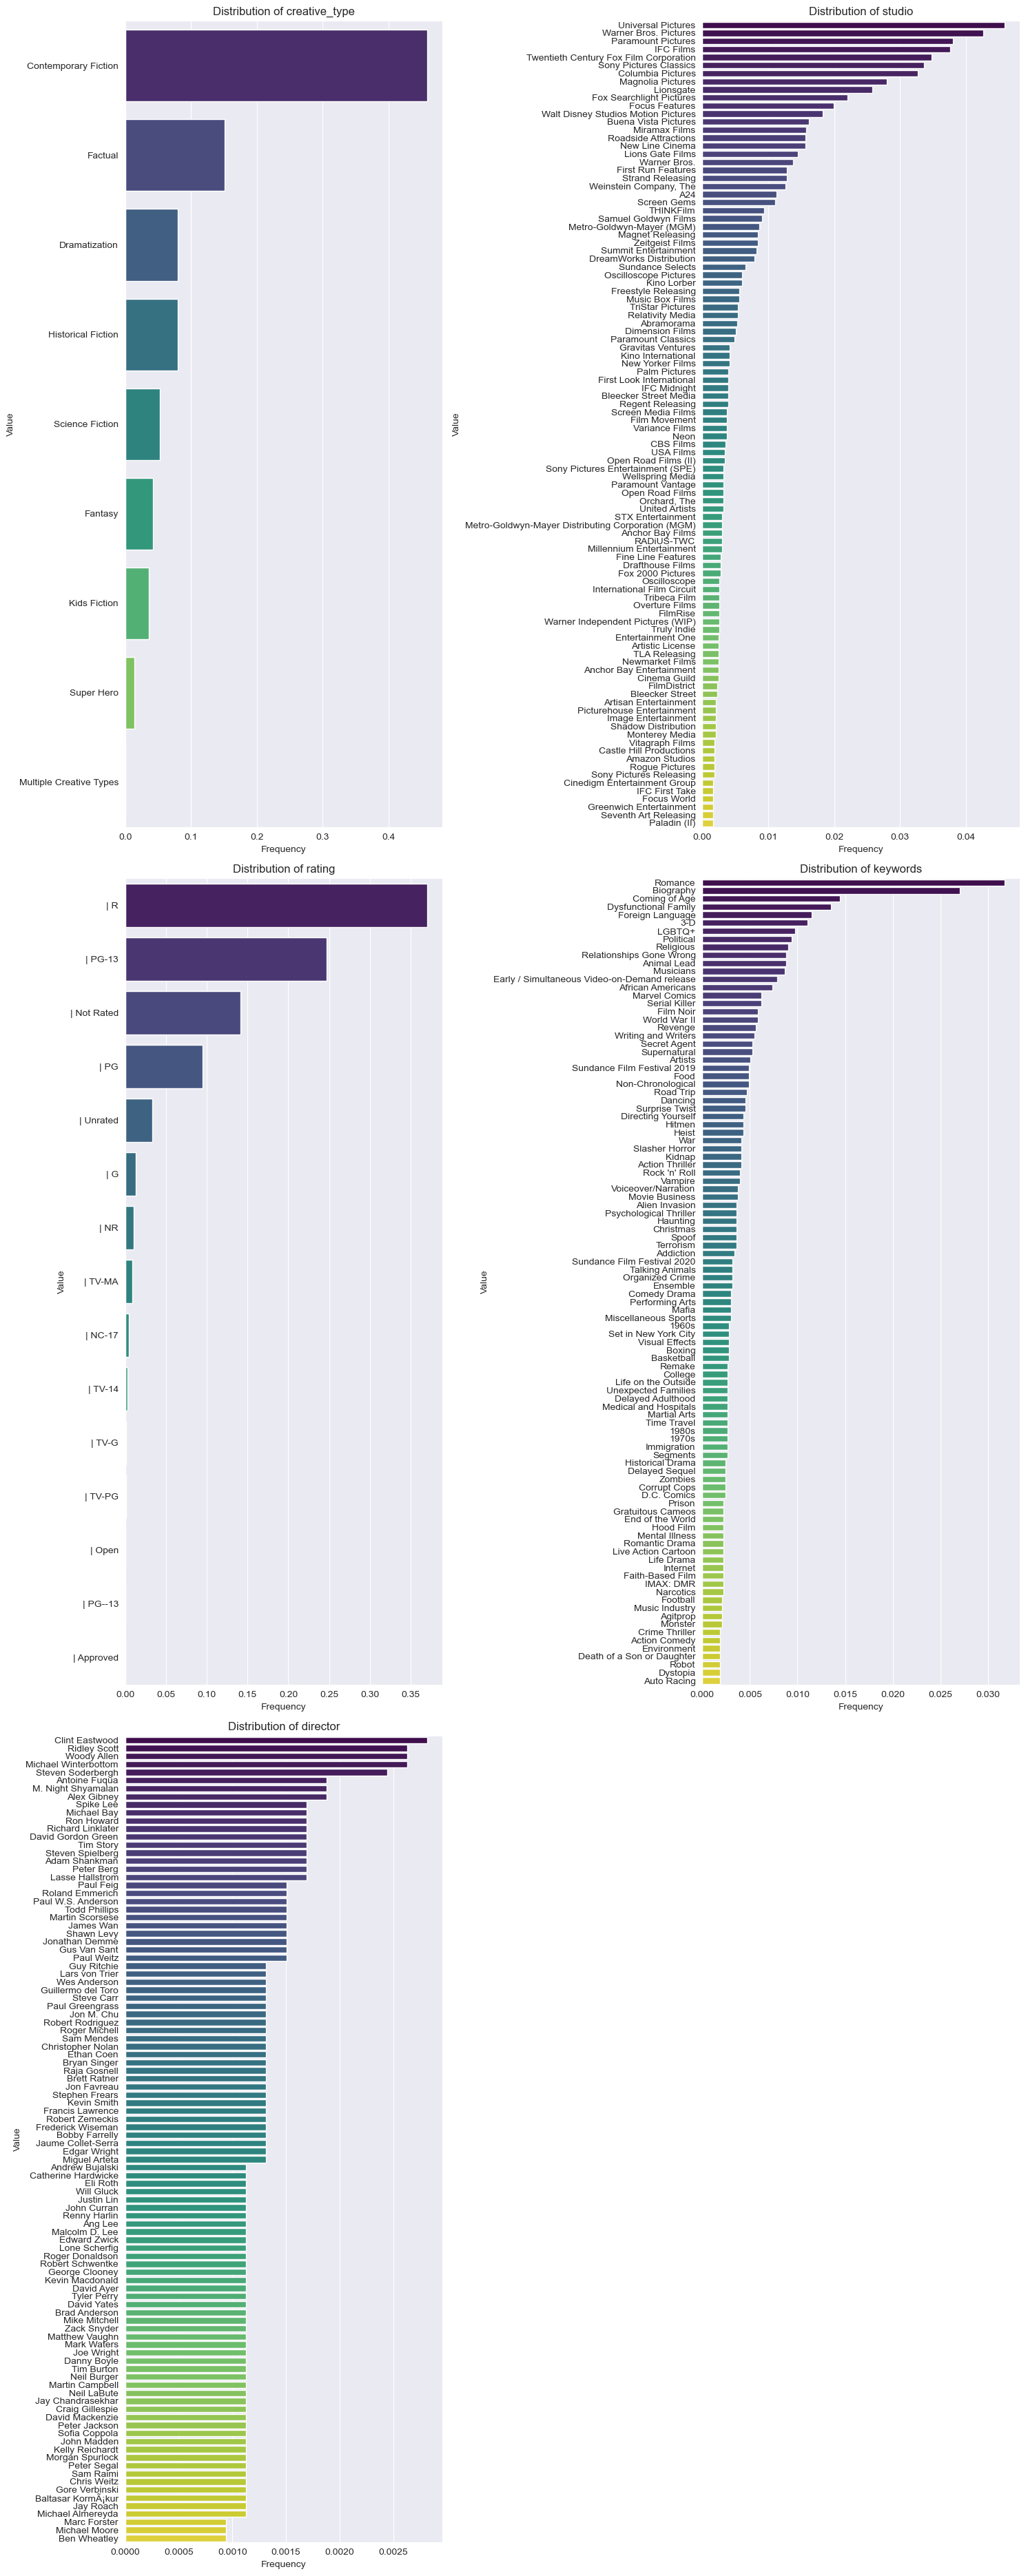

In [64]:
distribution_analyser.plot_categorical_relation_frequency(NOMINAL_SINGLE_VALUE_FEATURES, height=12.5)

Below the exploration of the relative frequency for the categorical features that presented as a list value. Here are the results:

1. `genre` - feature are divided very well, have only a few potential outliers
2. `cast` - the same as `director` feature

**Result recommendations**:
1. Drop `cast`

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_80596/1919121962.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=current_values.values, y=current_values.index, palette='viridis')
/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_80596/1919121962.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=current_values.values, y=current_values.index, palette='viridis')


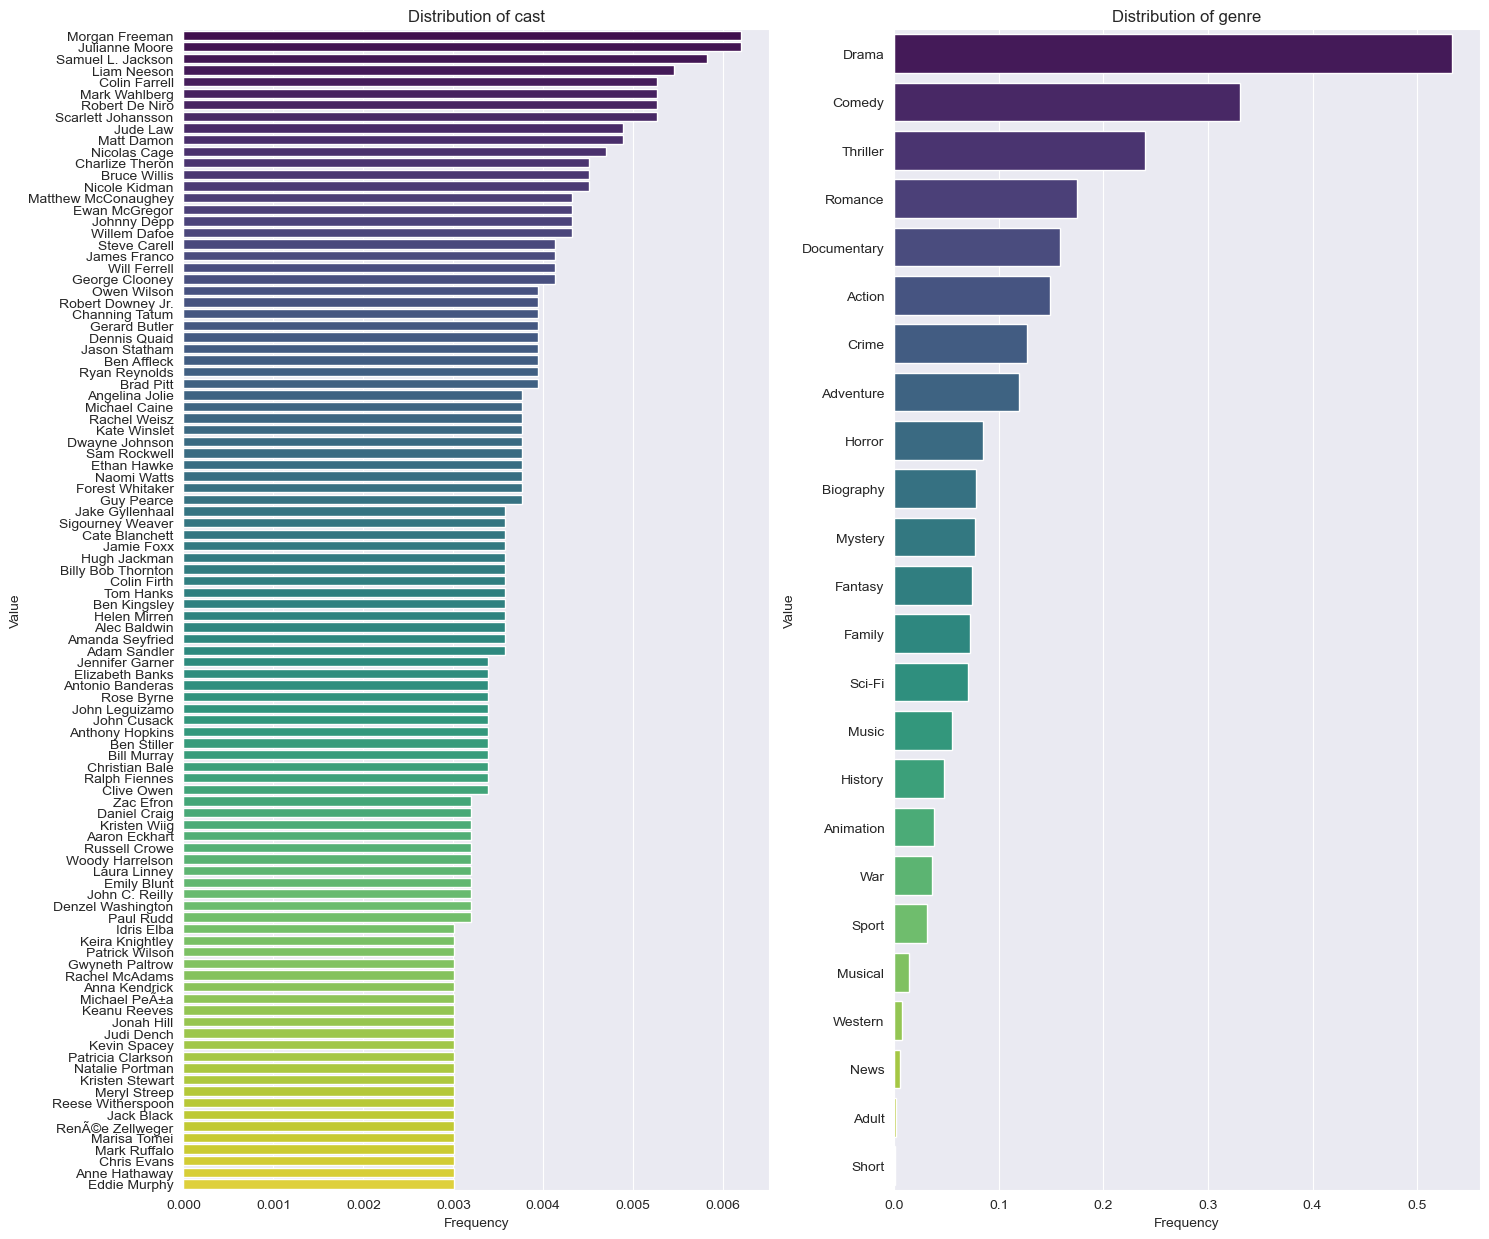

In [65]:
distribution_analyser.plot_categorical_relation_frequency(NOMINAL_MULTIPLE_VALUE_FEATURES, height=12.5)

### **DISTRIBUTION ANALYSIS OF THE CONTINIOUS VARIABLES**

Below there is explonation for numerical features distribution:
1. `runtime` - has "bell-shaped" distribution already, there is nothing to do with that
2. `production_budget` - have "exponential-like" distribution and big amount of Nan values that must be replaced with the mean calculated based on other feature (or total mean). After that, distribution must be rechecked and if its form remains, then it's necessary to apply logarifm to get "bell-shaped" distribution (affect ElasticNet and ANN's model).
3. `theatre_count` - has "exponential-like" distribution that has big heavy tails. Even after the logarithm application, must probably feature will have two well-separated peaks. With high correlation to the target feature potentially may become "killer" feature via basically creating the binary classification (if you have big theater counter that you don't have to pay attention to other feature and set big openning weekend and vice versa)
4. `openning_weekend` - target feature with exponential or hyperexponential distribution. For that feature it's necessary to apply logarifm (probably to base 3 or 4) to try to reduce disbalance in the results in train dataset, because we want to follow **common trend** more than concrete situations

**Final recommendations**:
1. Check correlation for theather count and decide either this is potentially killer feature or not
2. Apply logarifms for all the features except for `runtime`
3. For production budget recheck distribution after the Nan-replacement

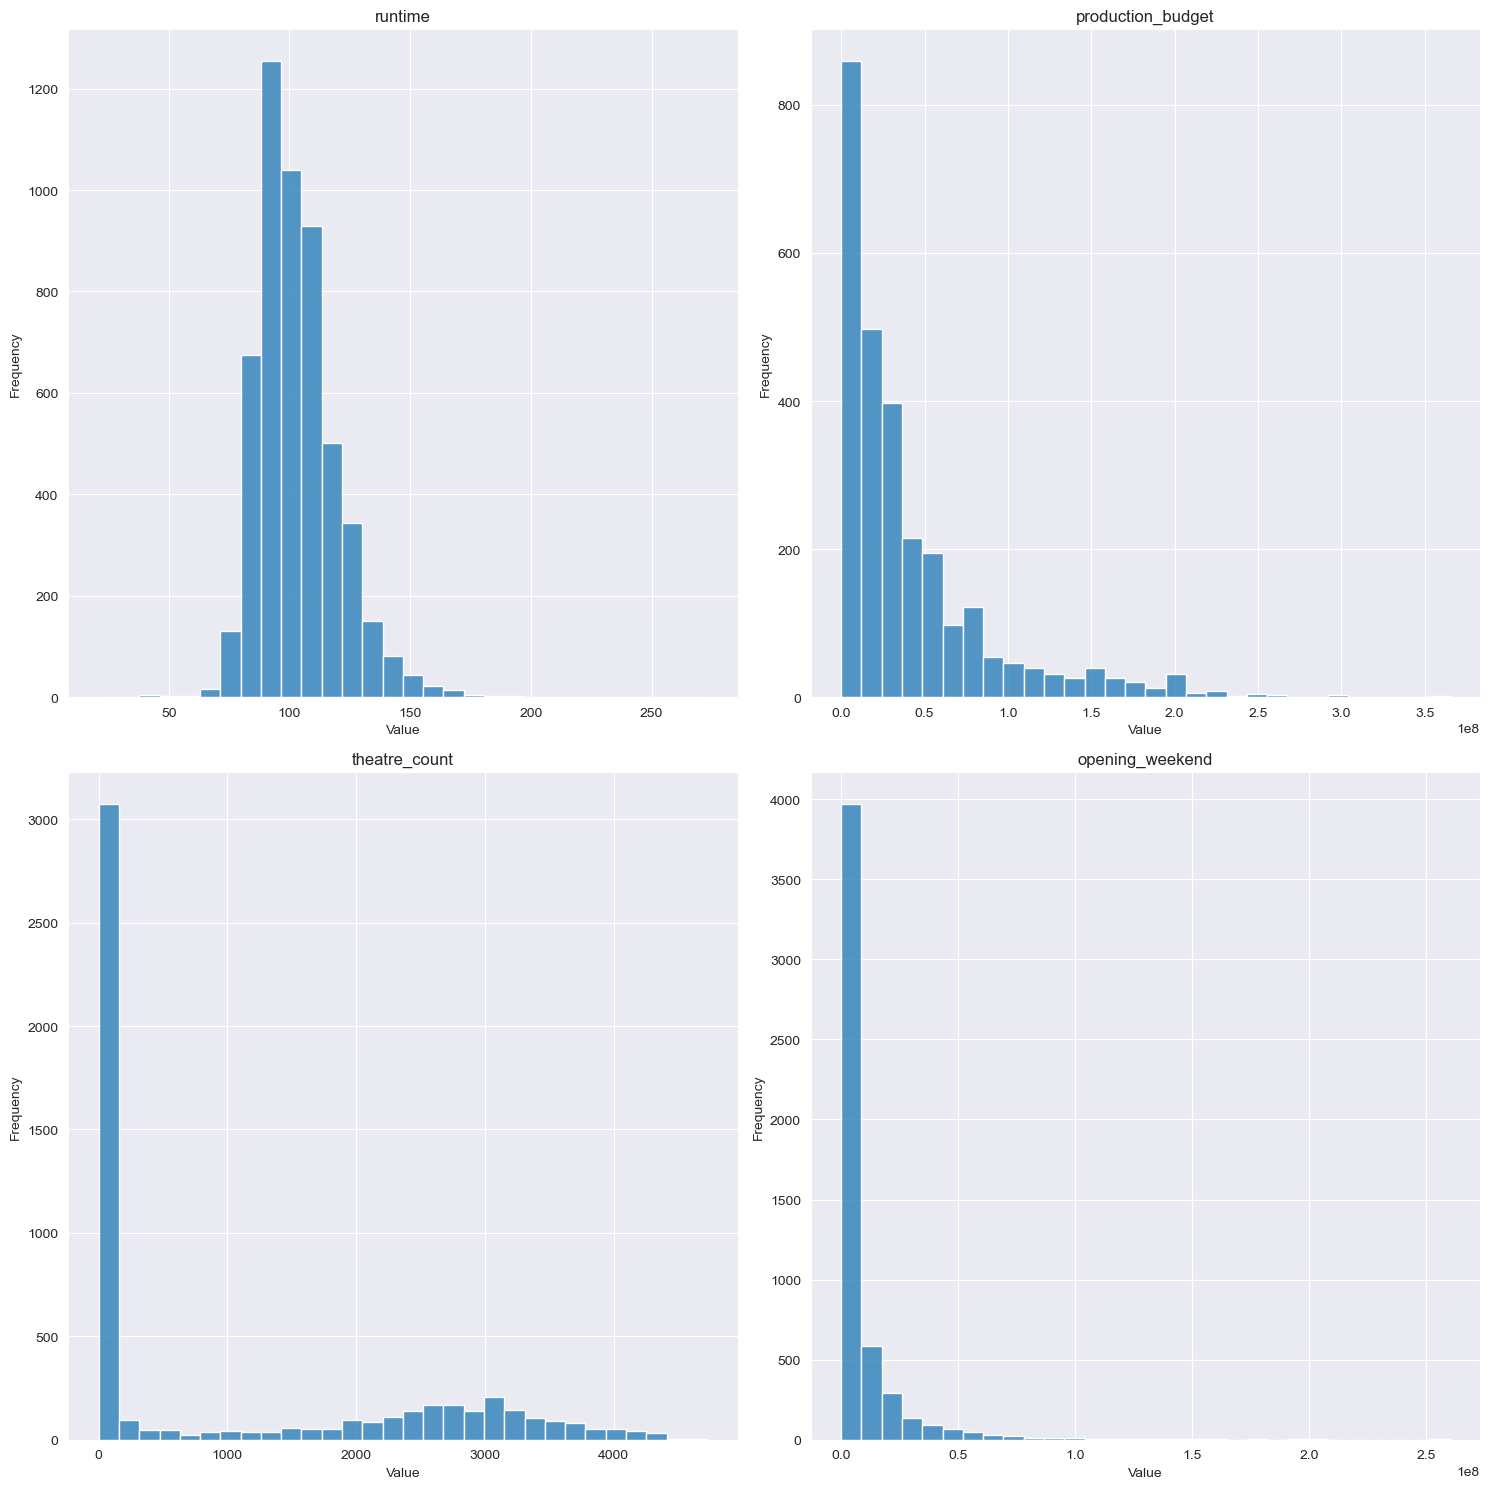

In [66]:
distribution_analyser.plot_numerical_distributions(NUMERICAL_FEATURES + [TARGET_FEATURE])

### **CONTINIOUS FEATURES CORRELATION ANALYSIS**

In [67]:
numeric_features = preprod_train_data[NUMERICAL_FEATURES + [TARGET_FEATURE]]

The Pearson correlation matrix highlights key relationships between **runtime**, **production budget**, and **opening weekend revenue**:

- The strongest correlation (**0.72**) is observed between **production budget** and **opening weekend revenue**, indicating that higher budgets are associated with better box office performance during the opening weekend.
- **Runtime** shows weaker correlations, with a moderate correlation (**0.40**) to **production budget**, suggesting that more expensive movies tend to be slightly longer, and a weak correlation (**0.28**) to **opening weekend revenue**, implying minimal influence on initial box office performance.
- **Theater count** shows high correlation to target feature and **production budget**, but we still can't make any conclusions because linear dependency wasn't proved

Overall, **production budget** emerges as the most impactful variable for predicting opening weekend success.


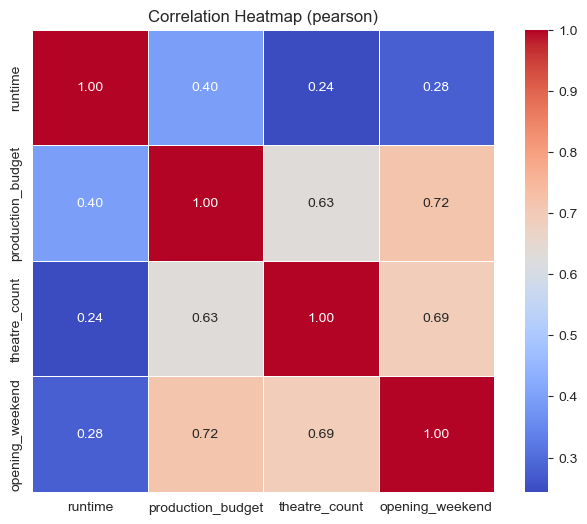

In [68]:
plot_correlation_matrix(numeric_features, method='pearson')

The Spearman correlation heatmap reveals the monotonic relationships between **runtime**, **production budget**, and **opening weekend revenue**:

- **Runtime** and **production budget** have a moderate correlation (**0.37**), indicating that longer movies tend to have somewhat higher production budgets, but the relationship is not particularly strong.
- **Production budget** maintains a strong correlation (**0.73**) with **opening weekend revenue**, confirming that movies with higher budgets are more likely to achieve better box office performance during their opening weekend.
- **Runtime** and **opening weekend revenue** exhibit a weak correlation (**0.33**), suggesting that a movie's length has a minimal monotonic relationship with its opening weekend revenue.
- Despite the fact that **theather count** has very high correlation it also has cross-corellation with **production_budget** so one of them shoulb be dropped. According to the strange **theater count** distribution that potentially may cause to the **killer feature** appearance, it's better to drop it

Overall, the **production budget** stands out as the most impactful variable for predicting opening weekend revenue, with runtime having less predictive value in this context. Spearman correlation emphasizes the rank-based relationships, which could be useful for understanding trends in non-linear associations.


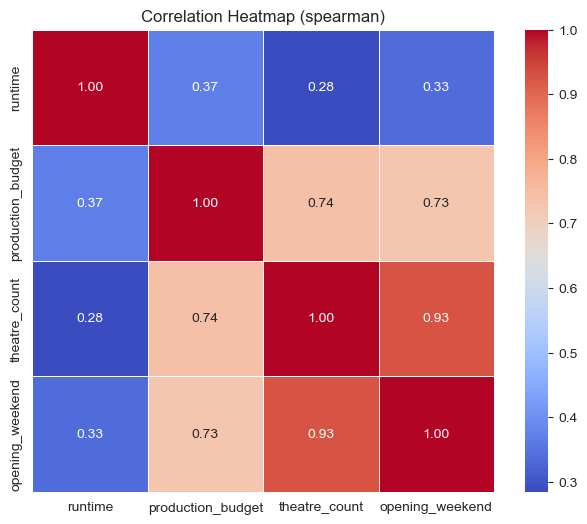

In [69]:
plot_correlation_matrix(numeric_features)

### **NOMINAL FEATURES CORRELATION ANALYSIS**

Here statistical testing are provided with the following approach:
1. Check nominallity and variance uniform
2. Use either one-way anova or kruskall-walls test to identify difference between the target values for feature's values
3. If the p-value is small enogh (< 0.05) then difference exist

Here we're exploring all the features, even those one who must have threshold or be dropped

As we can see, all the features has potential difference in target value between its values

In [70]:
get_p_for_nominal_data(preprod_train_data, NOMINAL_FEATURES, TARGET_FEATURE)

Feature: creative_type - p-value: 1.6637445114427018e-278 - there IS the difference in mean
Feature: studio - p-value: 0.0 - there IS the difference in mean
Feature: rating - p-value: 0.0 - there IS the difference in mean
Feature: keywords - p-value: 2.005390988268695e-146 - there IS the difference in mean
Feature: director - p-value: 2.8062649390768667e-11 - there IS the difference in mean
Feature: cast - p-value: 1.595350019590497e-57 - there IS the difference in mean
Feature: genre - p-value: 0.0 - there IS the difference in mean


## **FEATURE ENGINEERING** (SEMEN)

This chapter includes following changes for train and test datasets:
1. Feature dropping
2. Nan-values replacement
3. The application of threshold for nominal features
4. One-hot encoding + features syncronization

### **FEATURE DROPPING**

According to frequency analysis we have to drop following features:
- `cast`
- `director`

According to distribution and correlation analysis we have to drop following features:
- `theatre_count`

In [71]:
COLUMNS_TO_DROP = ['director', 'cast', 'theatre_count']

In [72]:
preprod_train_data_with_dropped_features = preprod_train_data.drop(COLUMNS_TO_DROP, axis=1)
preprod_test_data_with_dropped_features = preprod_test_data.drop(COLUMNS_TO_DROP, axis=1)

preprod_train_data_with_dropped_features.columns

Index(['studio', 'rating', 'runtime', 'genre', 'opening_weekend',
       'production_budget', 'creative_type', 'keywords'],
      dtype='object')

### **NAN-VALUES REPLACEMENT**

1. For nominal values there is no necessarity to replace Nan values as well as during the one-hot encoding they'll be dropped
2. `openning_weekend` doesn't have nan-values
3. 2% of nan values in `runtime` allows us to replace just with the mean
4. As well as `production_budget` has almost 50% of Nan-values we can't just apply the replacement with the mean. Instead, we'll calculate the mean for each value of the `rating` and replace with that. `rating` has less values and nan-values, and more equally distributed than other nominal features. If a row doesn't have rating then we'll replace it with the general mean.

Before all the replacement it's necessary to remove outliers to calculate **means**. We chose **quartile method** for that as well as not all of the features initially have bell-like distribution.

Also we're replacing nan values with the mean of the feature of all data that we have (**train + test**), because otherwise we can face with the problem that test dataset represent unreal data. At the same time all the decisions about replacement are based on the **train dataset EDA**.

In [73]:
preprod_train_data_with_nan_replacement, preprod_test_data_with_nan_replacement = duplicate_datasets(preprod_train_data_with_dropped_features, preprod_test_data_with_dropped_features)

preprod_train_data_with_nan_replacement

,studio,rating,runtime,genre,opening_weekend,production_budget,creative_type,keywords
Key_Title,,,,,,,,
A House On A Hill20031,Calliope Films,NaN,89.0,[Drama],678.0,NaN,NaN,NaN
The Vow20121,Screen Gems,| PG-13,104.0,"[Drama, Romance]",41202458.0,30000000.0,Historical Fiction,Romance
Antwone Fisher20021,Fox Searchlight Pictures,| PG-13,120.0,"[Biography, Drama, Romance]",210013.0,12500000.0,Dramatization,Biography
Tamara20061,Lions Gate Films,| R,98.0,"[Thriller, Fantasy, Horror]",29157.0,NaN,Fantasy,NaN
The Guest20141,Picturehouse,| R,99.0,"[Action, Mystery, Thriller]",84527.0,NaN,Contemporary Fiction,Returning Soldiers
...,...,...,...,...,...,...,...,...
Peter Pan20031,Universal Pictures,| PG,113.0,"[Adventure, Fantasy, Romance, Family]",11139495.0,100000000.0,Fantasy,Pirates
The Good Heart20101,Magnolia Pictures,| R,95.0,[Drama],5955.0,3800000.0,Contemporary Fiction,NaN
The Grudge 220061,Columbia Pictures,| PG-13,102.0,"[Drama, Mystery, Thriller, Horror]",20825300.0,20000000.0,Contemporary Fiction,Haunting


Removing outliers for **initial** dataset to calculate means

In [74]:
initial_dataset_without_outliers = remove_outliers_by_quantile(merged_preprod_data_with_dropped_values, ['production_budget', 'runtime'])
initial_dataset_without_outliers

,studio,rating,runtime,cast,director,genre,opening_weekend,production_budget,creative_type,keywords,theatre_count
Key_Title,,,,,,,,,,,
10 Cloverfield Lane20161,Paramount Pictures,| PG-13,104.0,"[John Gallagher Jr., John Goodman, Mary Elizab...",Dan Trachtenberg,"[Action, Sci-Fi, Drama, Mystery, Thriller, Hor...",24727437.0,15000000.0,Contemporary Fiction,Kidnap,3391.0
10000 Bc20081,Warner Bros. Pictures,| PG-13,109.0,"[Camilla Belle, Marco Khan, Steven Strait]",Roland Emmerich,"[Adventure, Drama, Fantasy]",35867488.0,105000000.0,Historical Fiction,Visual Effects,3410.0
102 Dalmatians20001,Buena Vista Pictures,| G,100.0,"[GÃ©rard Depardieu, Glenn Close]",Kevin Lima,"[Comedy, Family]",19883351.0,85000000.0,Kids Fiction,Live Action Cartoon,2704.0
10Th Wolf20061,THINKFilm,| R,107.0,"[Brad Renfro, Giovanni Ribisi, James Marsden]",Robert Moresco,"[Drama, Mystery, Thriller, Crime]",20774.0,8000000.0,Dramatization,Mafia,6.0
12 Rounds20091,Fox Atomic,| PG-13,108.0,"[Ashley Scott, John Cena]",Renny Harlin,"[Action, Thriller, Crime]",5329240.0,20000000.0,Contemporary Fiction,NaN,2331.0
...,...,...,...,...,...,...,...,...,...,...,...
Zombieland Double Tap20191,Columbia Pictures,| R,99.0,"[Abigail Breslin, Avan Jogia, Bill Murray, Dan...",Ruben Fleischer,"[Action, Horror, Comedy]",26803104.0,48000000.0,Contemporary Fiction,Zombies,3468.0
Zookeeper20111,Columbia Pictures,| PG,104.0,[Kevin James],Frank Coraci,"[Comedy, Romance, Family]",20065617.0,80000000.0,Fantasy,Romance,3482.0
Zoolander20011,Paramount Pictures,| R,89.0,"[Ben Stiller, Owen Wilson]",Ben Stiller,[Comedy],15525043.0,28000000.0,Contemporary Fiction,Fashion,2507.0


Calculations the mean for `runtime` without outliers

In [75]:
runtime_mean = initial_dataset_without_outliers['runtime'].mean()
runtime_mean

105.05571847507332

Replacing with calculated mean for `runtime`

In [76]:
preprod_train_data_with_nan_replacement['runtime'] = preprod_train_data_with_nan_replacement['runtime'].fillna(runtime_mean)

preprod_train_data_with_nan_replacement['runtime'].isna().sum()

0

In [77]:
preprod_test_data_with_nan_replacement['runtime'] = preprod_test_data_with_nan_replacement['runtime'].fillna(runtime_mean)

preprod_test_data_with_nan_replacement['runtime'].isna().sum()

0

Calculating means of `production_budget` for `rating` values and general mean of `production_budget`

In [78]:
production_budget_means = initial_dataset_without_outliers.groupby('rating')['production_budget'].mean()
production_budget_mean = initial_dataset_without_outliers['production_budget'].mean()

production_budget_mean

29599915.542196155

Replacing nan in `production_budget`

In [79]:
# If there is "production_budget" - remain it
# If there is no "rating" or its value doesn't exist in the mean's map (because of the outlier's removal that was applied before) - general mean of "production budget"
# Otherwise - map[row['rating]]

def replace_production_budget(df):
   return df.apply(
        lambda row: production_budget_mean if pd.isna(row['rating']) or row['rating'] not in production_budget_means else production_budget_means[row['rating']] if pd.isna(row['production_budget']) else row['production_budget'], axis=1
   )

In [80]:
preprod_train_data_with_nan_replacement['production_budget'] = replace_production_budget(preprod_train_data_with_nan_replacement)

preprod_train_data_with_nan_replacement['production_budget'].isna().sum()

0

In [81]:
preprod_test_data_with_nan_replacement['production_budget'] = replace_production_budget(preprod_test_data_with_nan_replacement)

preprod_test_data_with_nan_replacement['production_budget'].isna().sum()

0

### **THRESHOLD APPLICATION FOR NOMINAL FEATURES**

According to frequency analysis it's necessary to drop the values below the frequency threshold:
1. For `keywords` it's **0.005**
2. For `studio` it's **0.01**

In [82]:
preprod_train_data_threshold_aplied, preprod_test_data_threshold_aplied = duplicate_datasets(preprod_train_data_with_nan_replacement, preprod_test_data_with_nan_replacement)
preprod_train_data_threshold_aplied

,studio,rating,runtime,genre,opening_weekend,production_budget,creative_type,keywords
Key_Title,,,,,,,,
A House On A Hill20031,Calliope Films,NaN,89.0,[Drama],678.0,2.959992e+07,NaN,NaN
The Vow20121,Screen Gems,| PG-13,104.0,"[Drama, Romance]",41202458.0,3.000000e+07,Historical Fiction,Romance
Antwone Fisher20021,Fox Searchlight Pictures,| PG-13,120.0,"[Biography, Drama, Romance]",210013.0,1.250000e+07,Dramatization,Biography
Tamara20061,Lions Gate Films,| R,98.0,"[Thriller, Fantasy, Horror]",29157.0,2.318626e+07,Fantasy,NaN
The Guest20141,Picturehouse,| R,99.0,"[Action, Mystery, Thriller]",84527.0,2.318626e+07,Contemporary Fiction,Returning Soldiers
...,...,...,...,...,...,...,...,...
Peter Pan20031,Universal Pictures,| PG,113.0,"[Adventure, Fantasy, Romance, Family]",11139495.0,1.000000e+08,Fantasy,Pirates
The Good Heart20101,Magnolia Pictures,| R,95.0,[Drama],5955.0,3.800000e+06,Contemporary Fiction,NaN
The Grudge 220061,Columbia Pictures,| PG-13,102.0,"[Drama, Mystery, Thriller, Horror]",20825300.0,2.000000e+07,Contemporary Fiction,Haunting


In [83]:
columns_to_thresholds = {
    'keywords': 0.005,
    'studio': 0.01
}

Removing values below the thresholds in train dataset.

It is possible to see that the amount of the values decreased dramatically.

In [84]:
preprod_train_data_threshold_aplied = remove_below_threshold(preprod_train_data_threshold_aplied, columns_to_thresholds)
preprod_train_data_threshold_aplied[columns_to_thresholds.keys()].nunique()

keywords    38
studio      23
dtype: int64

We **don't have to** do the same with test dataset, because in the next chapter all the values that don't appear in the train dataset will be removed

### **ONE-HOT ENCODING + FEATURE SYNCRONIZATION**

During this part we are applying **one-hot encoding techique** for both of the datasets with the following approach:

- every value become feature
- values that don't appear in the train dataset become Nan in test dataset and don't have column
- if in the train dataset there is the value that doesn't appear in the test dataset, it's necessary to add columns with the names of this values to test dataset. Columns must contain only **0**

In [85]:
preprod_train_data_one_hot, preprod_test_data_one_hot = duplicate_datasets(preprod_train_data_threshold_aplied, preprod_test_data_threshold_aplied)
preprod_train_data_threshold_aplied

,studio,rating,runtime,genre,opening_weekend,production_budget,creative_type,keywords
Key_Title,,,,,,,,
A House On A Hill20031,NaN,NaN,89.0,[Drama],678.0,2.959992e+07,NaN,NaN
The Vow20121,Screen Gems,| PG-13,104.0,"[Drama, Romance]",41202458.0,3.000000e+07,Historical Fiction,Romance
Antwone Fisher20021,Fox Searchlight Pictures,| PG-13,120.0,"[Biography, Drama, Romance]",210013.0,1.250000e+07,Dramatization,Biography
Tamara20061,Lions Gate Films,| R,98.0,"[Thriller, Fantasy, Horror]",29157.0,2.318626e+07,Fantasy,NaN
The Guest20141,NaN,| R,99.0,"[Action, Mystery, Thriller]",84527.0,2.318626e+07,Contemporary Fiction,NaN
...,...,...,...,...,...,...,...,...
Peter Pan20031,Universal Pictures,| PG,113.0,"[Adventure, Fantasy, Romance, Family]",11139495.0,1.000000e+08,Fantasy,NaN
The Good Heart20101,Magnolia Pictures,| R,95.0,[Drama],5955.0,3.800000e+06,Contemporary Fiction,NaN
The Grudge 220061,Columbia Pictures,| PG-13,102.0,"[Drama, Mystery, Thriller, Horror]",20825300.0,2.000000e+07,Contemporary Fiction,NaN


Separating nominal features from the rest of the features

In [86]:
RESULT_NOMINAL_COLUMNS = list(set(NOMINAL_FEATURES) - set(COLUMNS_TO_DROP))
RESULT_NOMINAL_COLUMNS

['rating', 'studio', 'keywords', 'creative_type', 'genre']

In [87]:
# Extracting nominal values
train_nominal_candidates, test_nominal_candidates = preprod_train_data_one_hot[RESULT_NOMINAL_COLUMNS], preprod_test_data_one_hot[RESULT_NOMINAL_COLUMNS]
train_nominal_candidates

,rating,studio,keywords,creative_type,genre
Key_Title,,,,,
A House On A Hill20031,NaN,NaN,NaN,NaN,[Drama]
The Vow20121,| PG-13,Screen Gems,Romance,Historical Fiction,"[Drama, Romance]"
Antwone Fisher20021,| PG-13,Fox Searchlight Pictures,Biography,Dramatization,"[Biography, Drama, Romance]"
Tamara20061,| R,Lions Gate Films,NaN,Fantasy,"[Thriller, Fantasy, Horror]"
The Guest20141,| R,NaN,NaN,Contemporary Fiction,"[Action, Mystery, Thriller]"
...,...,...,...,...,...
Peter Pan20031,| PG,Universal Pictures,NaN,Fantasy,"[Adventure, Fantasy, Romance, Family]"
The Good Heart20101,| R,Magnolia Pictures,NaN,Contemporary Fiction,[Drama]
The Grudge 220061,| PG-13,Columbia Pictures,NaN,Contemporary Fiction,"[Drama, Mystery, Thriller, Horror]"


In [88]:
preprod_train_data_one_hot

,studio,rating,runtime,genre,opening_weekend,production_budget,creative_type,keywords
Key_Title,,,,,,,,
A House On A Hill20031,NaN,NaN,89.0,[Drama],678.0,2.959992e+07,NaN,NaN
The Vow20121,Screen Gems,| PG-13,104.0,"[Drama, Romance]",41202458.0,3.000000e+07,Historical Fiction,Romance
Antwone Fisher20021,Fox Searchlight Pictures,| PG-13,120.0,"[Biography, Drama, Romance]",210013.0,1.250000e+07,Dramatization,Biography
Tamara20061,Lions Gate Films,| R,98.0,"[Thriller, Fantasy, Horror]",29157.0,2.318626e+07,Fantasy,NaN
The Guest20141,NaN,| R,99.0,"[Action, Mystery, Thriller]",84527.0,2.318626e+07,Contemporary Fiction,NaN
...,...,...,...,...,...,...,...,...
Peter Pan20031,Universal Pictures,| PG,113.0,"[Adventure, Fantasy, Romance, Family]",11139495.0,1.000000e+08,Fantasy,NaN
The Good Heart20101,Magnolia Pictures,| R,95.0,[Drama],5955.0,3.800000e+06,Contemporary Fiction,NaN
The Grudge 220061,Columbia Pictures,| PG-13,102.0,"[Drama, Mystery, Thriller, Horror]",20825300.0,2.000000e+07,Contemporary Fiction,NaN


In [89]:
# Removing nominal values
preprod_train_data_rest, preprod_test_data_rest = preprod_train_data_one_hot.drop(RESULT_NOMINAL_COLUMNS, axis=1), preprod_test_data_one_hot.drop(RESULT_NOMINAL_COLUMNS, axis=1)
preprod_train_data_rest

,runtime,opening_weekend,production_budget
Key_Title,,,
A House On A Hill20031,89.0,678.0,2.959992e+07
The Vow20121,104.0,41202458.0,3.000000e+07
Antwone Fisher20021,120.0,210013.0,1.250000e+07
Tamara20061,98.0,29157.0,2.318626e+07
The Guest20141,99.0,84527.0,2.318626e+07
...,...,...,...
Peter Pan20031,113.0,11139495.0,1.000000e+08
The Good Heart20101,95.0,5955.0,3.800000e+06
The Grudge 220061,102.0,20825300.0,2.000000e+07


Replacing with one-hot encoded features

In [90]:
one_hot_encoder = OneHotEncoder(train_nominal_candidates)
train_one_hot = one_hot_encoder.replace_with_one_hot_encoded(RESULT_NOMINAL_COLUMNS)
train_one_hot

,rating_| Approved,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG--13,rating_| PG-13,rating_| R,...,keywords_Writing and Writers,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero
Key_Title,,,,,,,,,,,,,,,,,,,,,
A House On A Hill20031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Vow20121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Antwone Fisher20021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tamara20061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
The Guest20141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
The Good Heart20101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Grudge 220061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
one_hot_encoder.set_df(test_nominal_candidates)
test_one_hot = one_hot_encoder.replace_with_one_hot_encoded(RESULT_NOMINAL_COLUMNS)
test_one_hot

,rating_| G,rating_| MA-17,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,...,keywords_Young Child Dealing with the Death of a Parent,keywords_Zombies,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero
Key_Title,,,,,,,,,,,,,,,,,,,,,
Vantage Point20081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Advanced Style20141,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Meeting Resistance20071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Spree20201,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dunkirk20171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Place Beyond The Pines20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Mouthful Of Air20211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anchorman 2 The Legend Continues20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Syncroniztion of the values in train and test dataset via extracting the common features

In [92]:
common_columns = train_one_hot.columns.intersection(test_one_hot.columns)
common_columns

Index(['rating_| G', 'rating_| NC-17', 'rating_| NR', 'rating_| Not Rated',
       'rating_| Open', 'rating_| PG', 'rating_| PG-13', 'rating_| R',
       'rating_| TV-14', 'rating_| TV-MA', 'rating_| TV-PG',
       'rating_| Unrated', 'studio_ The', 'studio_A24',
       'studio_Buena Vista Pictures', 'studio_Columbia Pictures',
       'studio_First Run Features', 'studio_Focus Features',
       'studio_Fox Searchlight Pictures', 'studio_IFC Films',
       'studio_Lions Gate Films', 'studio_Lionsgate',
       'studio_Magnolia Pictures', 'studio_Miramax Films',
       'studio_New Line Cinema', 'studio_Paramount Pictures',
       'studio_Roadside Attractions', 'studio_Screen Gems',
       'studio_Sony Pictures Classics', 'studio_Strand Releasing',
       'studio_Twentieth Century Fox Film Corporation',
       'studio_Universal Pictures',
       'studio_Walt Disney Studios Motion Pictures', 'studio_Warner Bros.',
       'studio_Warner Bros. Pictures', 'studio_Weinstein Company',
       'ke

In [93]:
train_one_hot = train_one_hot[common_columns]
train_one_hot

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,keywords_World War II,keywords_Writing and Writers,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero
Key_Title,,,,,,,,,,,,,,,,,,,,,
A House On A Hill20031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Vow20121,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Antwone Fisher20021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Tamara20061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
The Guest20141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
The Good Heart20101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Grudge 220061,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
test_one_hot = test_one_hot[common_columns]
test_one_hot

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,keywords_World War II,keywords_Writing and Writers,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero
Key_Title,,,,,,,,,,,,,,,,,,,,,
Vantage Point20081,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Advanced Style20141,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Meeting Resistance20071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Spree20201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dunkirk20171,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Place Beyond The Pines20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Mouthful Of Air20211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anchorman 2 The Legend Continues20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Joining the one-hot encoded dataset and the rest of the features

In [95]:
preprod_train_data = pd.merge(train_one_hot, preprod_train_data_rest, left_index=True, right_index=True)
preprod_train_data

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,opening_weekend,production_budget
Key_Title,,,,,,,,,,,,,,,,,,,,,
A House On A Hill20031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,678.0,2.959992e+07
The Vow20121,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,104.0,41202458.0,3.000000e+07
Antwone Fisher20021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,210013.0,1.250000e+07
Tamara20061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,98.0,29157.0,2.318626e+07
The Guest20141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,84527.0,2.318626e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,113.0,11139495.0,1.000000e+08
The Good Heart20101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0,5955.0,3.800000e+06
The Grudge 220061,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,20825300.0,2.000000e+07


In [96]:
preprod_test_data = pd.merge(test_one_hot, preprod_test_data_rest, left_index=True, right_index=True)
preprod_test_data

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,opening_weekend,production_budget
Key_Title,,,,,,,,,,,,,,,,,,,,,
Vantage Point20081,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,22874936.0,4.000000e+07
Advanced Style20141,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,6500.0,8.765621e+06
Meeting Resistance20071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,84.0,7712.0,2.959992e+07
Spree20201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.0,20480.0,8.765621e+06
Dunkirk20171,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,50513488.0,1.500000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Place Beyond The Pines20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,279457.0,1.500000e+07
A Mouthful Of Air20211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,130701.0,2.300000e+06
Anchorman 2 The Legend Continues20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,119.0,26232425.0,5.000000e+07


### **DISTRIBUTION CHANGES**

In [97]:
RESULT_NUMERICAL_FEATURES = list(set(NUMERICAL_FEATURES) - set(COLUMNS_TO_DROP))

In [98]:
RESULT_NUMERICAL_FEATURES_WITH_TARGET = RESULT_NUMERICAL_FEATURES + [TARGET_FEATURE]
RESULT_NUMERICAL_FEATURES_WITH_TARGET

['runtime', 'production_budget', 'opening_weekend']

Define columns that are necessary to change

In [99]:
COLUMNS_TO_CHANGE = ['production_budget', 'opening_weekend']

Applying box-cox to `production_budget` and `opening_weekend` features to change their distributions to bell-shaped

In [100]:
preprod_train_data_numerical_changed, _ = apply_box_cox(preprod_train_data, COLUMNS_TO_CHANGE)
preprod_train_data_numerical_changed

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,opening_weekend,production_budget
Key_Title,,,,,,,,,,,,,,,,,,,,,
A House On A Hill20031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,5.817210,352.863673
The Vow20121,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,104.0,13.012340,354.131204
Antwone Fisher20021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,9.914823,280.211478
Tamara20061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,98.0,8.596988,330.575515
The Guest20141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,9.318965,330.575515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,113.0,12.298662,488.196567
The Good Heart20101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0,7.467190,203.546707
The Grudge 220061,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,12.644226,317.766364


After box-cox it's possible to mention that:

1. `production_budged` distribution became more "bell-shaped"
2. `opening_weekend` has two peaks, but data became more equally distributed across the numerical axis so we remain this transformation. It means that we've two groups of movies: with very high feature and very low. It can create the problems with the corner cases.

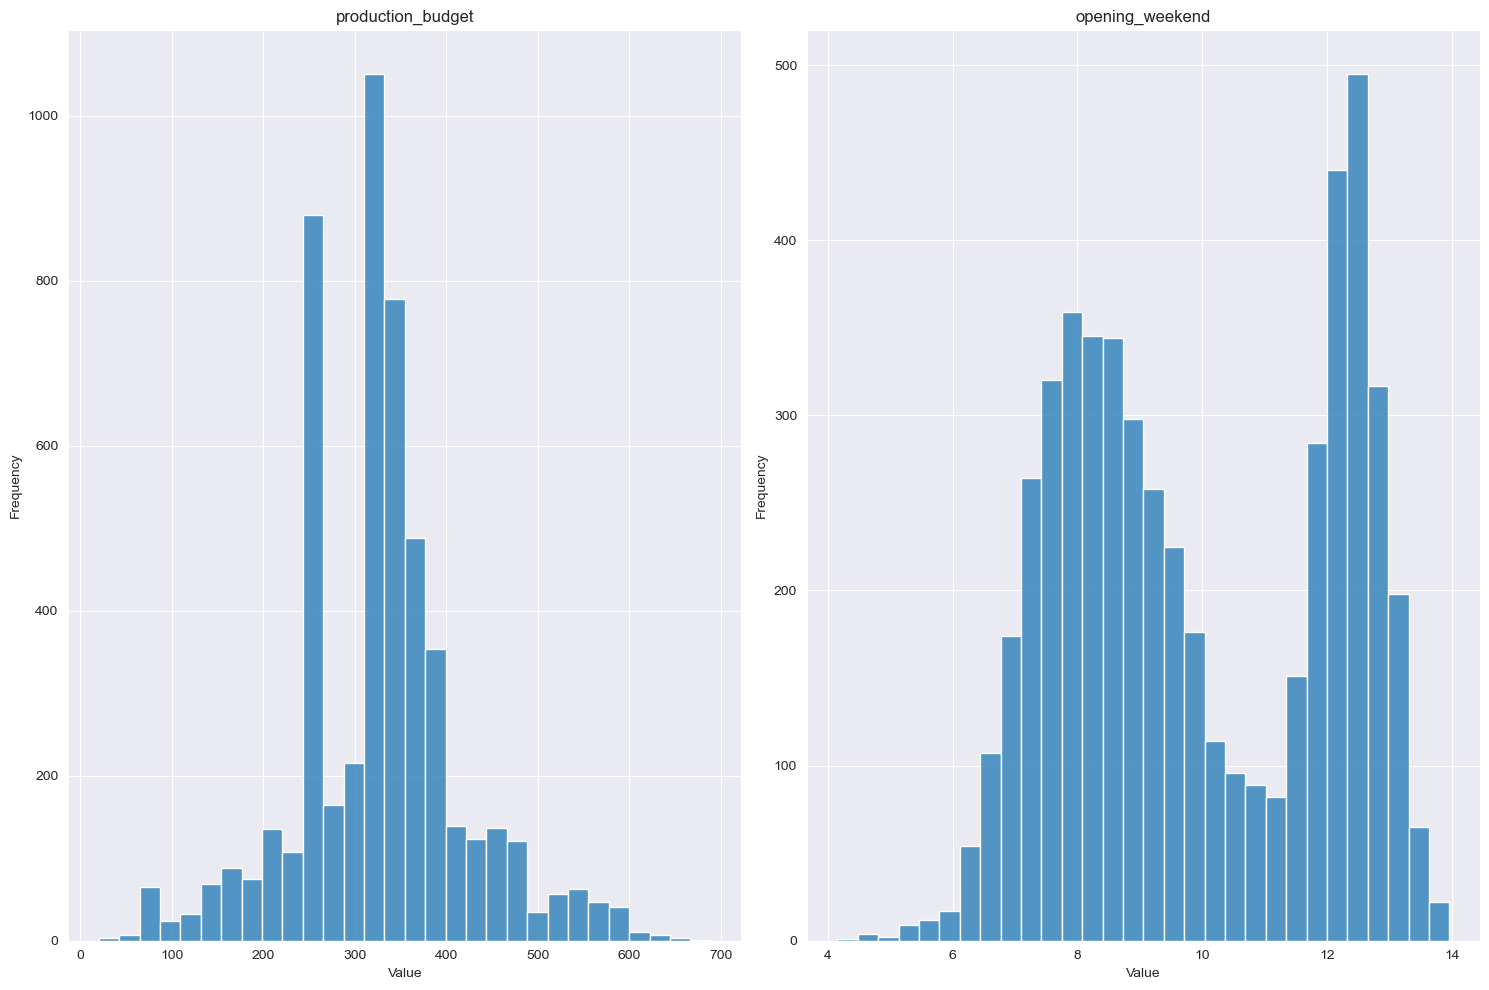

In [101]:
distribution_analyser_applied = DistributionAnalyser(preprod_train_data_numerical_changed)
distribution_analyser_applied.plot_numerical_distributions(COLUMNS_TO_CHANGE)

Apply the same for test dataset

In [102]:
preprod_test_data_numerical_changed, LAMBDA_BOX_COX_TEST = apply_box_cox(preprod_test_data, COLUMNS_TO_CHANGE)

### **SCALING**

Apply standard scaling to the numerical features (including target, because this is important for distance-based models such as MLP)

In [103]:
preprod_train_data_numerical_scaled, train_scaler = standard_scale_columns(preprod_train_data_numerical_changed, RESULT_NUMERICAL_FEATURES_WITH_TARGET)
preprod_test_data_numerical_scaled, test_scaler = standard_scale_columns(preprod_test_data_numerical_changed, RESULT_NUMERICAL_FEATURES_WITH_TARGET)

preprod_train_data_numerical_scaled

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,opening_weekend,production_budget
Key_Title,,,,,,,,,,,,,,,,,,,,,
A House On A Hill20031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.839040,-1.928569,0.264517
The Vow20121,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051336,1.430281,0.278312
Antwone Fisher20021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001070,-0.015710,-0.526174
Tamara20061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.304815,-0.630905,0.021950
The Guest20141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.245456,-0.293870,0.021950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.585561,1.097121,1.737377
The Good Heart20101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.482890,-1.158321,-1.360536
The Grudge 220061,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.067381,1.258438,-0.117456


As we can see, distribution remains the same

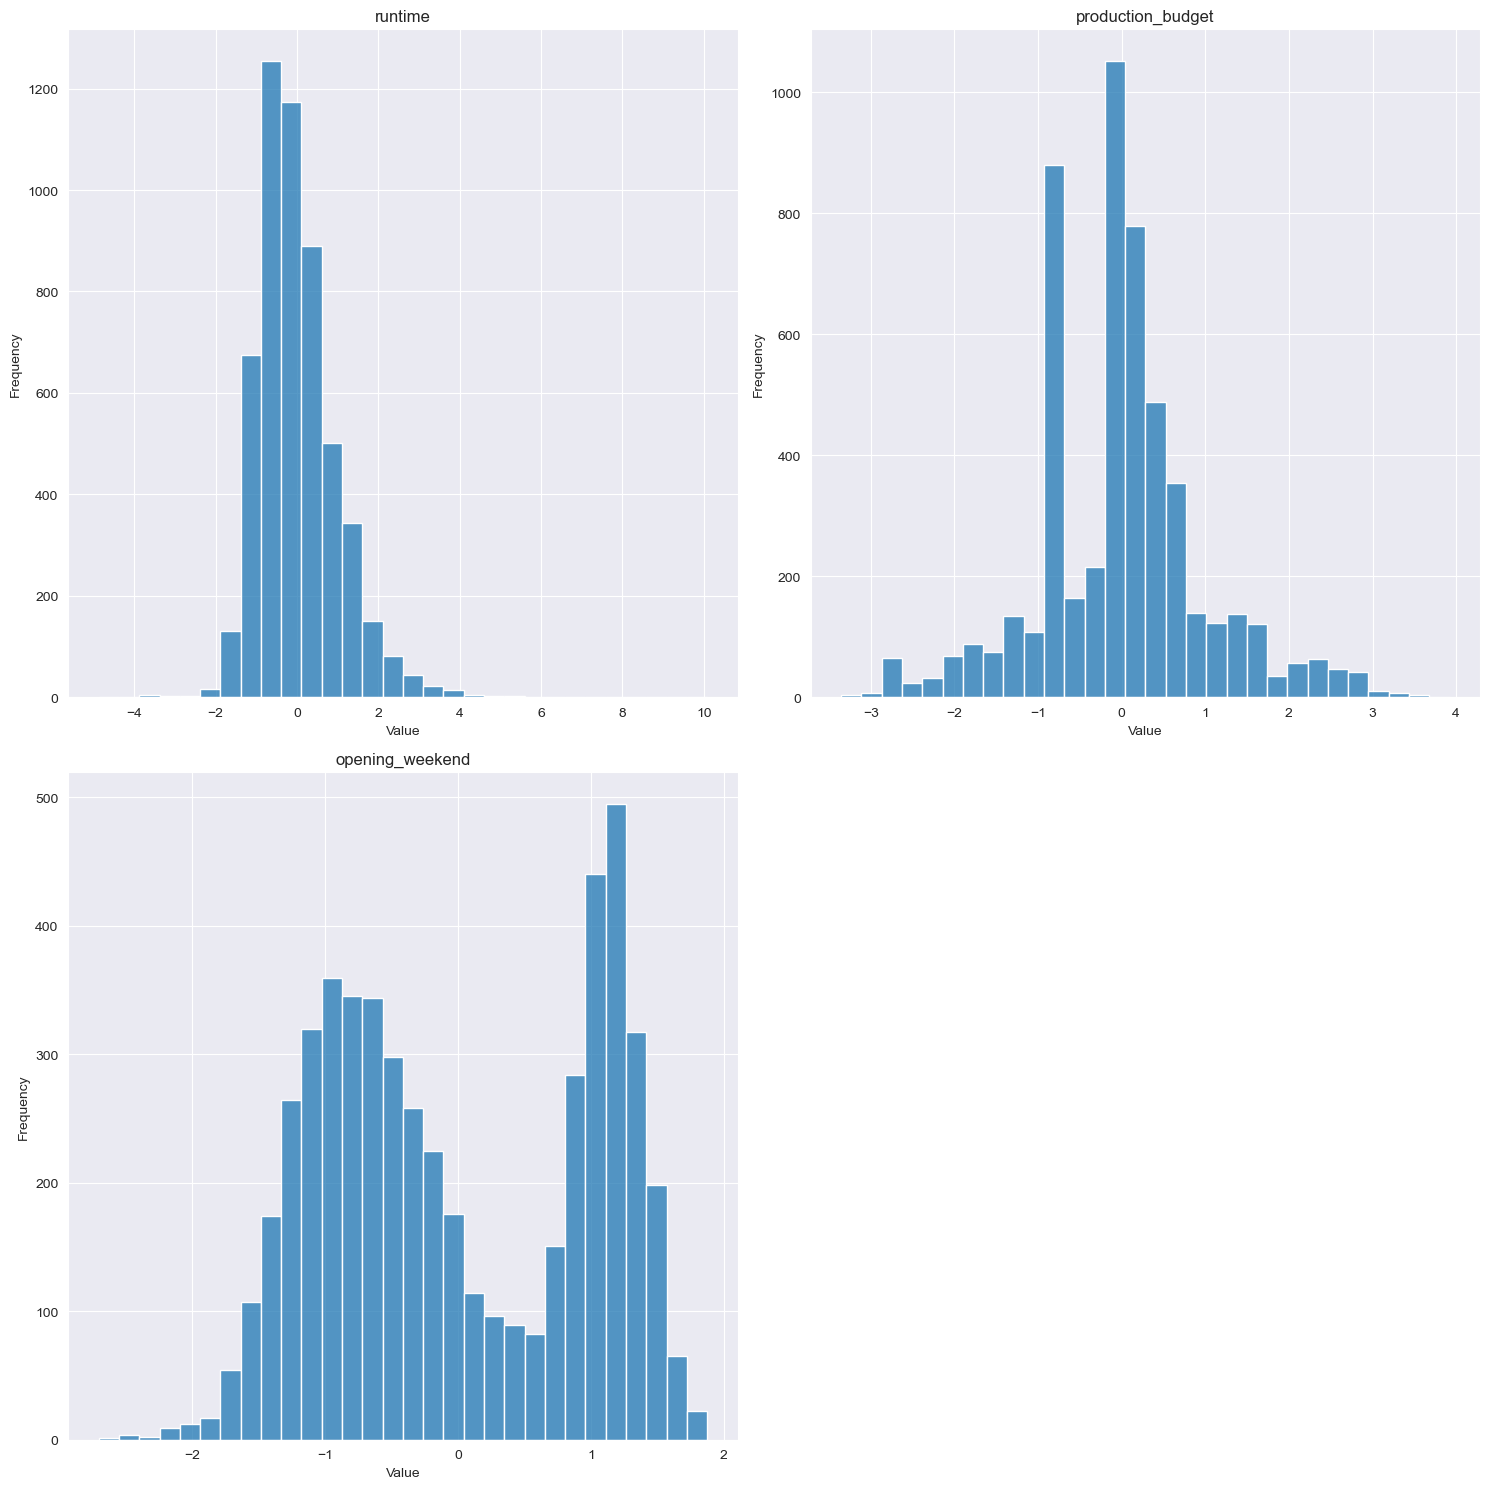

In [104]:
distribution_analyser_applied = DistributionAnalyser(preprod_train_data_numerical_scaled)
distribution_analyser_applied.plot_numerical_distributions(RESULT_NUMERICAL_FEATURES_WITH_TARGET) 

Merge result numerical features to initial datasets

In [105]:
preprod_train_data = preprod_train_data_numerical_scaled
preprod_test_data = preprod_test_data_numerical_scaled

preprod_train_data

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,opening_weekend,production_budget
Key_Title,,,,,,,,,,,,,,,,,,,,,
A House On A Hill20031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.839040,-1.928569,0.264517
The Vow20121,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051336,1.430281,0.278312
Antwone Fisher20021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001070,-0.015710,-0.526174
Tamara20061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.304815,-0.630905,0.021950
The Guest20141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.245456,-0.293870,0.021950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.585561,1.097121,1.737377
The Good Heart20101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.482890,-1.158321,-1.360536
The Grudge 220061,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.067381,1.258438,-0.117456


## **MODELLING** (SEMEN)

Separating X from Y in the train dataset

In [106]:
preprod_X_train, preprod_Y_train = preprod_train_data.drop([TARGET_FEATURE], axis=1), preprod_train_data[TARGET_FEATURE]
preprod_X_train

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget
Key_Title,,,,,,,,,,,,,,,,,,,,,
A House On A Hill20031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.839040,0.264517
The Vow20121,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051336,0.278312
Antwone Fisher20021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001070,-0.526174
Tamara20061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.304815,0.021950
The Guest20141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.245456,0.021950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Peter Pan20031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.585561,1.737377
The Good Heart20101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.482890,-1.360536
The Grudge 220061,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.067381,-0.117456


Find the best model via cross-validation:
1. Create object that provide the interface
2. Complete cross-validation with **5** folds for each model (all possible variants of hyperparameters are located in class) - we chose MSE as a metric to provide the models that can follow corner cases the best way
3. Check elbow on MLP's loss function
4. Set the number of epochs
5. With the best hyperparameters train all the models (KNN, RandomForest and MLPRegressor)
6. Check trade-off between variance and bias^2

In [107]:
selector = ModelSelector(preprod_X_train, preprod_Y_train)

In [108]:
selector.cross_validate_and_select(cv=5, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model: KNN, Best neg_mean_squared_error: -0.3420
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model: RandomForest, Best neg_mean_squared_error: -0.2577
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Model: MLPRegressor, Best neg_mean_squared_error: -0.2676


The optimal amount of epochs is **7**

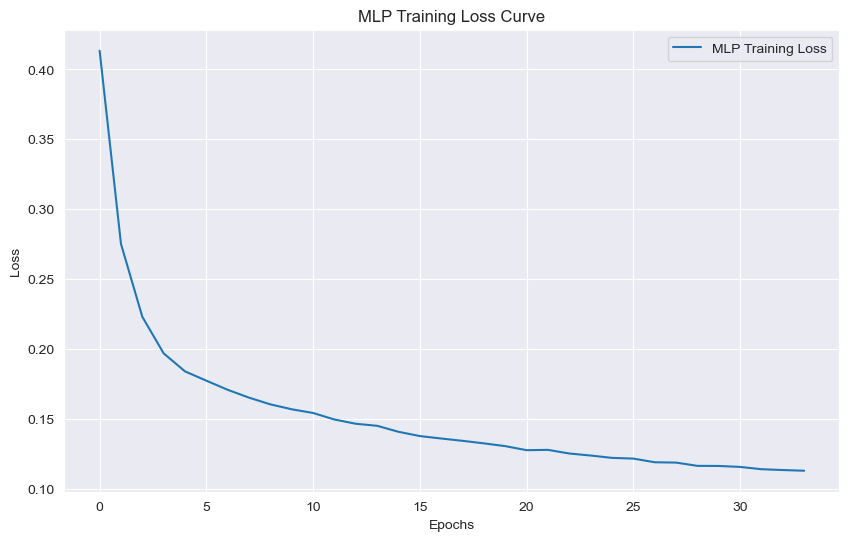

In [109]:
selector.plot_loss_curve()

In [110]:
selector.set_best_epochs(7)

Set MLPRegressor epochs to 7


Training the models with the best hyperparameters

In [111]:
selector.train_all_models()

Training KNN with best hyperparameters...
KNN trained with parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}
Training RandomForest with best hyperparameters...
RandomForest trained with parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training MLPRegressor with best hyperparameters...
MLPRegressor trained with parameters: {'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 7, 'validation_fraction': 0.2}


Separating X from Y in the test dataset

In [112]:
preprod_X_test, preprod_Y_test = preprod_test_data.drop([TARGET_FEATURE], axis=1), preprod_test_data[TARGET_FEATURE]
preprod_X_test

,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget
Key_Title,,,,,,,,,,,,,,,,,,,,,
Vantage Point20081,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.728066,0.556746
Advanced Style20141,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.700573,-0.894583
Meeting Resistance20071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.052235,0.227894
Spree20201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.565981,-0.894583
Dunkirk20171,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136385,2.297665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Place Beyond The Pines20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.973343,-0.436945
A Mouthful Of Air20211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082357,-1.819240
Anchorman 2 The Legend Continues20131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.838751,0.815333


As we can see on the plots with trade-off all the models **underfitted**, because of the lack of the data (Bias is still reducing, but variance still low). 5000 rows isn't enough to fit well.

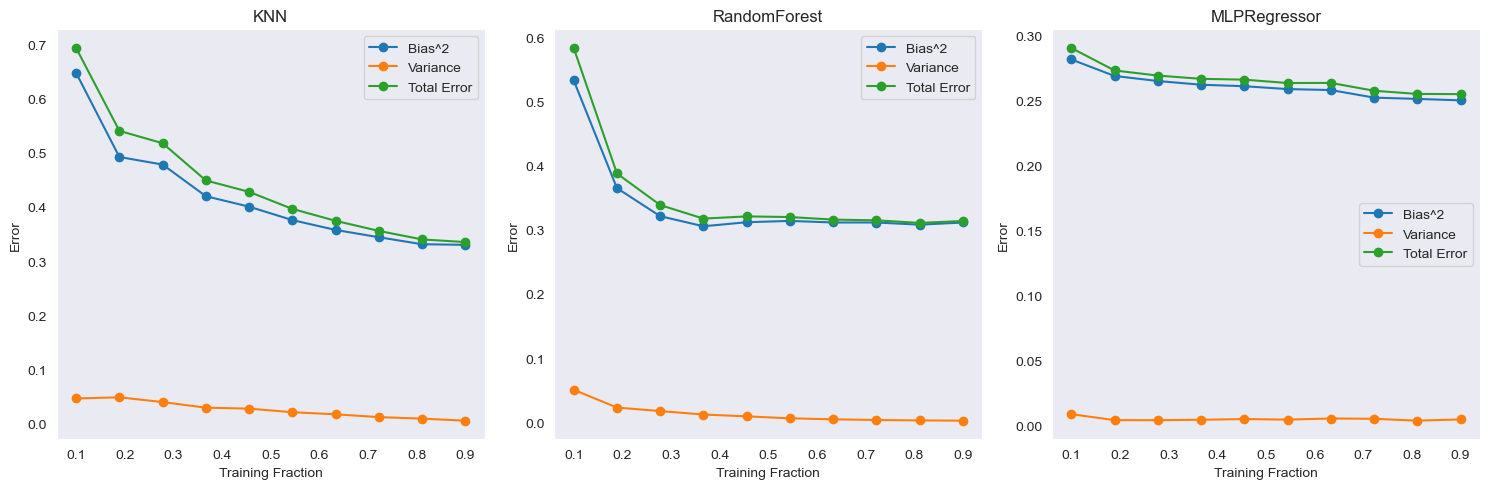

In [113]:
selector.plot_bias_variance_tradeoff(preprod_X_test, preprod_Y_test)

## **SELECTION** (SEMEN)

Below the function that convert the predicted values back to the initial numbers

In [114]:
def reverse_preparation(prediction):
    idx = RESULT_NUMERICAL_FEATURES_WITH_TARGET.index(TARGET_FEATURE)
    mean = test_scaler.mean_[idx]
    std = test_scaler.scale_[idx]

    return reverse_box_cox(reverse_standard_scale(prediction, mean, std), LAMBDA_BOX_COX_TEST[TARGET_FEATURE])

This is the class that provide evaluation methods such as calculation of the metrics and drawing actual vs predicted plots

In [115]:
evaluator = ModelEvaluator(selector.models, preprod_X_test, preprod_Y_test)

The metrics below shows that KNN and RandomForest are extremely underfitted and don't cover the covariance (R^2 < 0 => covers less covariance then mean).

At the same time MLP has less amount of the problems with outliers than other models, but has bigger average error (MAE is bigger, RMSE is less)

In [116]:
# RMSE
evaluator.evaluate(metric=rmse_calculation, transform_target=reverse_preparation)

{'KNN': 13258468.353117328,
 'RandomForest': 13810321.35527565,
 'MLPRegressor': 13487076.650736563}

In [117]:
# R^2
evaluator.evaluate(metric=r_squared, transform_target=reverse_preparation)

{'KNN': -0.5026688870629425,
 'RandomForest': -1.4590510039105054,
 'MLPRegressor': 0.5809955160298138}

In [118]:
# MAE
evaluator.evaluate(metric=mae_calculation, transform_target=reverse_preparation)

{'KNN': 5187799.674601081,
 'RandomForest': 5029281.429657057,
 'MLPRegressor': 5223235.519893487}

On the plots it's possible to mention that MLP **overestimate** predictions in corner cases (and mostly) while other models **underestimate** it 

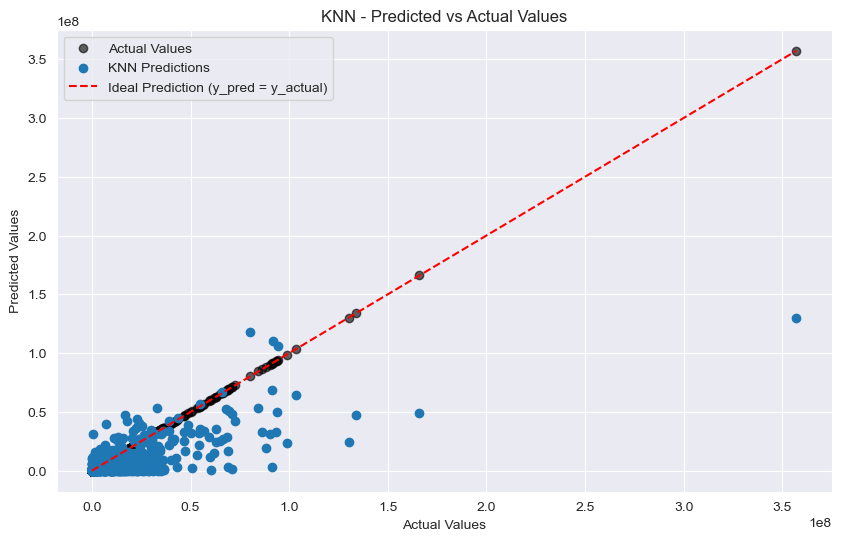

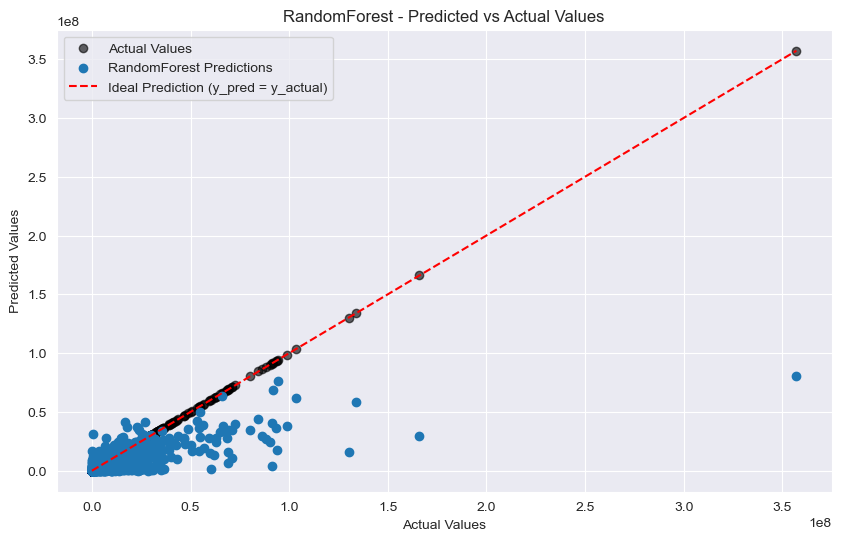

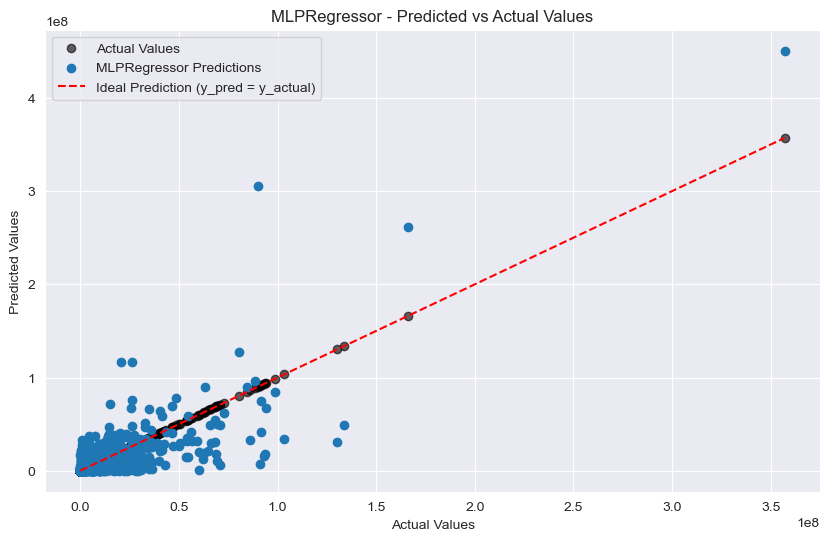

In [119]:
evaluator.plot_predictions(transform_target=reverse_preparation)

In the end, despite the **underfitting** and **overestimating** we're choosing **MLPRegressor** as the best models across all the models and will explore that, because:
1. It has the best R^2 metric (the only positive)
2. It has the best sustainability with outliers
3. It doesn't overestimate the situations when target feature relatively small - only once - (danger business-case, because in that situation we're getting good result when truly we'll lose money)

## **EXPLANATION** (SEMEN)

Defining the best model

In [120]:
CHOSEN_MODEL = 'MLPRegressor'

In [242]:
explainer = ModelExplainer(model=selector.models[CHOSEN_MODEL])

Below the counterfactual method of explainability is located

Regretfully, de to we have 84 features and 81 of them are one-hot encoded features this method aren't really reliable and we can't make any concrete conclusions based on **10 counterfactuals** for **3 random rows**

However, this experiment showed that the model is underfitted, because it gave three identical predictions for three random rows

In [243]:
explainer.generate_counterfactuals(preprod_train_data, RESULT_NUMERICAL_FEATURES, TARGET_FEATURE, preprod_X_test)

100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

Query instance (original outcome : -1.0)


,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget,opening_weekend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511953,-0.022831,-1.0



Diverse Counterfactual set (new outcome: [-2.7044332532402615, 1.8738751621758465])


,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget,opening_weekend
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.5408560633659363
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.40037497878074646
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.3776431381702423
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.5538111925125122
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.4376949071884155
5,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.28852108120918274
6,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,1.0,-,-,0.5001844167709351
7,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.7542961239814758
8,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.07741131633520126
9,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.5320404767990112


Query instance (original outcome : -1.0)


,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget,opening_weekend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.052235,-2.626263,-1.0



Diverse Counterfactual set (new outcome: [-2.7044332532402615, 1.8738751621758465])


,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget,opening_weekend
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.7718453407287598
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.7718453407287598
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.7718453407287598
3,-,-,-,-,-,-,-,-,-,-,...,-,1.0,-,-,-,-,-,-,-,-0.10050906240940094
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.8068673610687256
5,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-1.39466933,0.0003756860096473247
6,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.957301676273346
7,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-1.0616822242736816
8,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.10290473699569702
9,-,-,-,-,-,-,-,-,-,-,...,-,1.0,-,-,-,-,-,-,-,-0.10050906240940094


Query instance (original outcome : -1.0)


,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget,opening_weekend
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082357,-0.894583,-1.0



Diverse Counterfactual set (new outcome: [-2.7044332532402615, 1.8738751621758465])


,rating_| G,rating_| NC-17,rating_| NR,rating_| Not Rated,rating_| Open,rating_| PG,rating_| PG-13,rating_| R,rating_| TV-14,rating_| TV-MA,...,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Science Fiction,creative_type_Super Hero,runtime,production_budget,opening_weekend
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.6392554044723511
1,-,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-0.09953121095895767
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.6392554044723511
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.6039453148841858
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.7904599905014038
5,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.6392554044723511
6,-,-,-,-,-,-,-,-,-,-,...,-,-,1.0,-,-,-,-,-,-,-0.07288338989019394
7,-,-,-,-,-,-,-,-,1.0,-,...,-,-,-,-,-,-,-,-,-,-0.5101638436317444
8,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.574980616569519
9,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.3125073313713074


Computed the SHAP values on the train dataset

As the result, we see that 
1. `production_budget` was killer feature during training period. However, there is almost no one case when big production 
2. `creative_type` feature defines the biggest impact on the prediction the same as `rating` feature

PermutationExplainer explainer: 5323it [18:28,  4.72it/s]                          


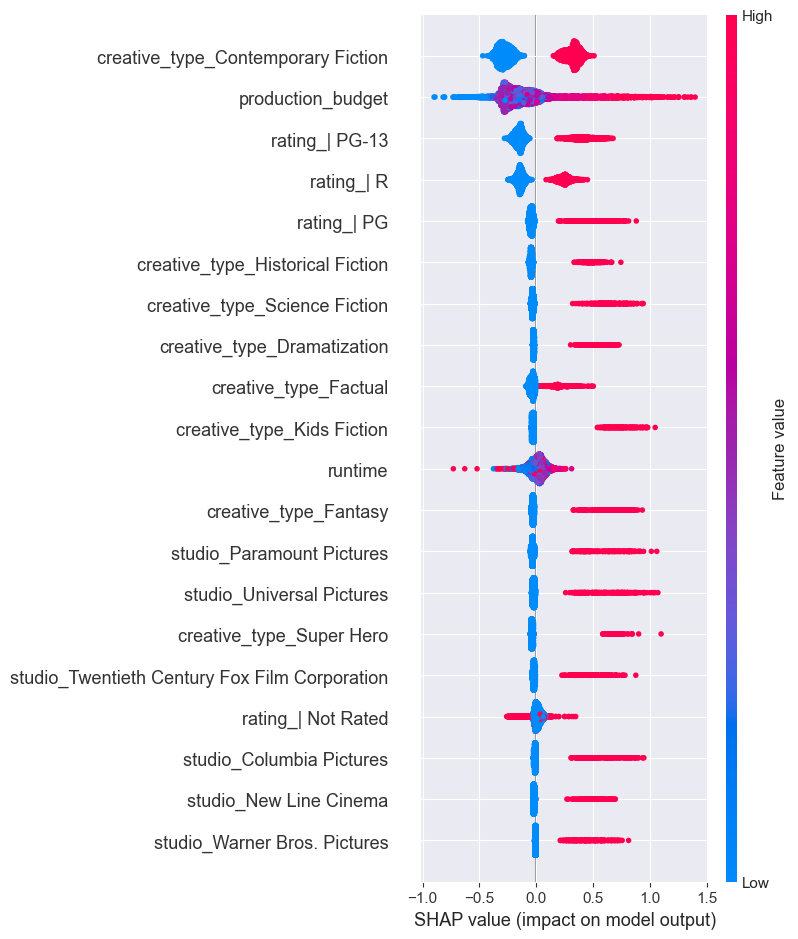

In [123]:
explainer.compute_shap_values(preprod_X_train)
explainer.plot_shap_summary()

Compute the SHAP values on the test dataset

Here we can see that the model had almost the same logic as in train dataset, but `runtime` this time doesn't affect predictions very much

PermutationExplainer explainer: 1332it [01:56,  9.63it/s]                          


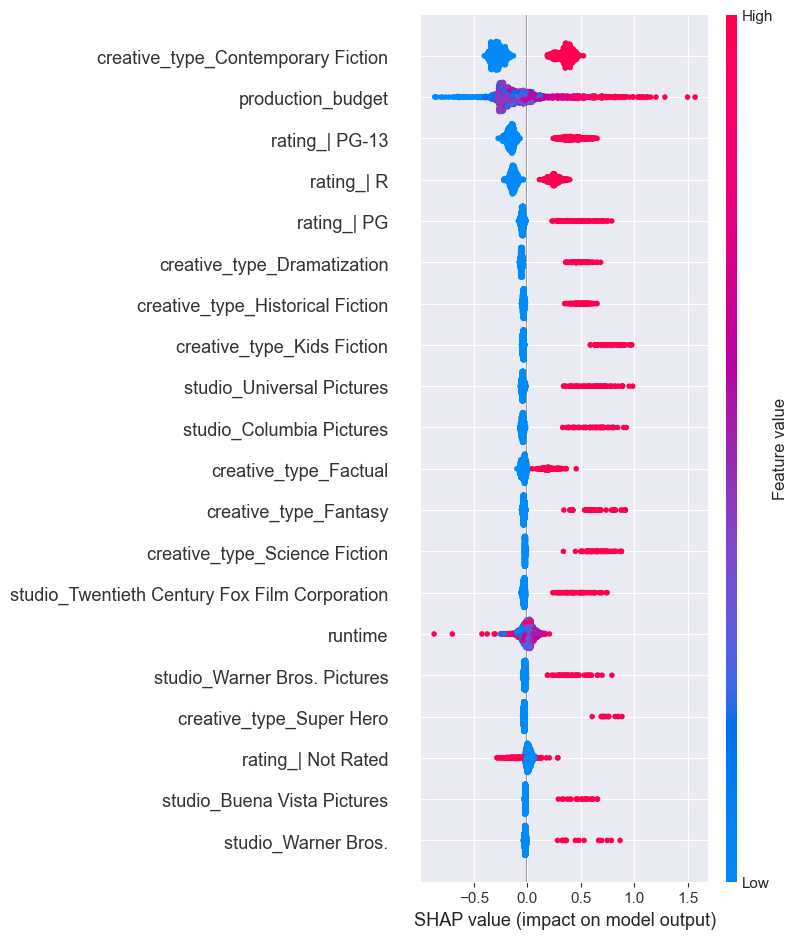

In [124]:
explainer.compute_shap_values(preprod_X_test)
explainer.plot_shap_summary()

In the end we can conclude:
1. `creative_type` and `rating` are the most important categorical features for model's predictions
2. `Contemporary_fiction`, `Dramatization` and ratings `PG-13`, `R`, `PG` have the most crucial role in the predictions
3. `production` is the most important continuous feature and the model relied on that during the training a lot

# **CONCLUSIONS**

1. We're experiencing the lack of training data to fit the models well (it's sparse matrix mostly because of the one-hot encoded features so it requires more data that we have)
2. As the best model MLP were chosen, but it's also underfitted and overestimates results in corner cases
3. "Contemporary fiction" creative type, rating "PG 13" and "R" and production budget affects the predicted value the most. We also can see that the model based its decision on the correlation that exist between target and production budget. The listed categories are the most important. 